# Επισκόπηση Εργασίας

Στην παρούσα εργασία μελετάται η δημιουργία ενός **RNN (BiLSTM με Attention)** για την ταξινόμηση σχολίων που αφορούν αεροπορικές εταιρείες.  
Οι ετικέτες (`labels`) είναι τρεις: **αρνητικά**, **ουδέτερα**, και **θετικά** σχόλια.

Η μελέτη ακολούθησε το παράδειγμα κώδικα που μας δόθηκε, με προσαρμογές και πειραματισμούς σε διαφορετικές παραμετροποιήσεις.

---

## Δημιουργία Embeddings

Για να μπορεί το μοντέλο να δουλέψει με **ακολουθίες tokens** (και όχι με μεμονωμένα χαρακτηριστικά όπως σε ένα απλό ANN), ήταν απαραίτητο να κατασκευάσουμε ένα **embedding layer**.  
Αυτό το embedding layer βασίστηκε σε προεκπαιδευμένα **Word2Vec embeddings**, ώστε κάθε token να έχει μία πυκνή αναπαράσταση σε χώρο 300 διαστάσεων.

- Τα tokens μετατράπηκαν σε ids με σταθερό μήκος ακολουθίας (`MAX_LEN`) μέσω padding και truncation.  
- Προστέθηκαν τα ειδικά tokens `<PAD>` (0) και `<UNK>` (1).  
- Το `<PAD>` γέμισε με μηδενικά, ενώ το `<UNK>` πήρε τον μέσο όρο όλων των γνωστών embeddings, για να έχει “ουδέτερη” αναπαράσταση.  
- Το embedding layer φορτώθηκε στο PyTorch μοντέλο με δυνατότητα fine-tuning.

Η ανάγκη για embeddings προκύπτει επειδή το RNN επεξεργάζεται **σειρές tokens** σε batches. Σε αντίθεση με ένα απλό ANN που δέχεται διανύσματα σταθερού μήκους (π.χ. TF-IDF), εδώ πρέπει να κρατηθεί η χρονική/σειριακή πληροφορία του κειμένου.

---

## Πειραματισμοί σε Τεχνικές

Δοκιμάστηκαν διάφορες τεχνικές βελτίωσης:

- **Dropout**: όπως και στην προηγούμενη εργασία, λειτούργησε καλά μειώνοντας το overfitting.  
- **Layer Normalization**: ευνόησε τις κλάσεις με μικρότερη εκπροσώπηση (positive, neutral), χωρίς να επηρεάσει αρνητικά την κλάση negative.  
- **Gradient Clipping**: βελτίωσε τα neutral αλλά αποδυνάμωσε σημαντικά τα positive, οπότε απορρίφθηκε.  
- **Residual Connections**: δεν πρόσφεραν βελτίωση.  
- **Hidden dimension & num_layers**: δεν έφεραν ουσιαστικό κέρδος, απλά αύξησαν το κόστος εκπαίδευσης.

---

## Επεξεργασία Δεδομένων

Αν και δεν ζητήθηκε, κρίθηκε απαραίτητο να γίνει επιπλέον **προεπεξεργασία** για καλύτερη κατανόηση από το μοντέλο:

- Χρήση **lemmatizer**: έφερε καλύτερα αποτελέσματα, πιθανόν επειδή τα tweets δεν ακολουθούν αυστηρό συντακτικό και έτσι μειώθηκαν οι “άγνωστες” λέξεις για το Word2Vec (όλες οι άγνωστες λέξεις ειχαν το ιδιο διάνυσμα `<UNK>`).  
- **Stopwords**: σε αντίθεση με την προηγούμενη εργασία (όπου κρατήθηκαν μόνο οι λέξεις άρνησης), εδώ διατηρήθηκαν όλα. Αυτό βοήθησε τις πιο αδύναμες κλάσεις (neutral, positive).  
- **Emojis/Emoticons**: τελικά δεν κρατήθηκαν, καθώς έδειξαν να ευνοούν δυσανάλογα την κλάση negative εις βάρος των άλλων.  

---

## Παρατηρήσεις για τα Αποτελέσματα

- Το accuracy και τα average metrics συσχετίζονται έντονα με την επιτυχία στην κλάση **negative**, που έχει και τη μεγαλύτερη εκπροσώπηση στο dataset.  
- Όταν ανέβαινε η ακρίβεια στα negative, βελτιώνονταν και οι συνολικές μετρικές· αντίθετα, όταν βελτιώνονταν οι neutral/positive αλλά έπεφταν τα negative, η συνολική απόδοση έπεφτε.  
- Αυτό οφείλεται στην ανισορροπία του dataset (κυριαρχία των negative tweets).

---

## Ροή Εργασίας

1. Παρουσίαση βιβλιοθηκών και βοηθητικών συναρτήσεων.  
2. Φόρτωση και προεπεξεργασία δεδομένων (EDA, καθαρισμός κειμένου, lemmatization).  
3. Δημιουργία λεξιλογίου, μετατροπή tokens σε ids, και κατασκευή embedding layer.  
4. Ορισμός του BiLSTM Attention μοντέλου.  
5. Εκπαίδευση με early stopping και scheduler.  
6. Αξιολόγηση με accuracy, classification report, confusion matrices.  

---

## Τεχνικές Παρατηρήσεις

Η εκπαίδευση του μοντέλου γινόταν με **πολύ αργούς ρυθμούς**, κάτι που δυσκόλεψε το fine-tuning εντός του διαθέσιμου χρόνου.  
Παρόλα αυτά, τα αποτελέσματα ήταν καλύτερα σε σχέση με τη προηγούμενη προσέγγιση (ANN), αποδεικνύοντας την καταλληλότητα του μοντέλου (RNN + embeddings) για το συγκεκριμένο πρόβλημα.

In [1]:
# --- Βασικές βιβλιοθήκες ---
import numpy as np
import pandas as pd
import re
import copy
import html
import matplotlib.pyplot as plt

# --- PyTorch ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Scikit-learn ---
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.decomposition import PCA

# --- NLP ---
import spacy
from gensim.models import KeyedVectors
# φορτώνουμε το αγγλικό μοντέλο μία φορά (κρατά tagger + lemmatizer)
nlp = spacy.load("en_core_web_sm")

# --- Για εξαγωγή σε pdf ---
from matplotlib.backends.backend_pdf import PdfPages  

# --- Ρυθμίσεις εμφάνισης pandas ---
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

### Emoji regex και emoji sets

**Σκοπός**  
- Ορισμός regex (`EMOJI_RE`) για εντοπισμό/αντικατάσταση emojis σε κείμενο.  
- Ορισμός τριών συνόλων emojis:  
  - `EMO_POS` → θετικά  
  - `EMO_NEG` → αρνητικά  
  - `EMO_NEU` → ουδέτερα  

Χρησιμοποιούνται σε συναρτήσεις όπως το `clean_text` και το `map_emojis_to_tokens`.

In [2]:
EMOJI_RE = re.compile(
    "["                                   # Unicode ranges για emojis
    u"\U0001F600-\U0001F64F"              # emoticons 🙂
    u"\U0001F300-\U0001F5FF"              # symbols & pictographs
    u"\U0001F680-\U0001F6FF"              # transport & map
    u"\U0001F1E0-\U0001F1FF"              # flags
    u"\U00002700-\U000027BF"              # misc symbols
    u"\U0001F900-\U0001F9FF"              # supplemental symbols
    "]+", flags=re.UNICODE
)

# --- απλό emoji mapping ---
EMO_POS = set("😀😃😄😁🙂😊🥰😍😘😎🤩👍👏🎉✨💯❤️💕💖💙💚💛💜💗💓💞🤗👌")
EMO_NEG = set("😞😟😠😡😔😢😭😫🤬👎💔🙁☹️")
EMO_NEU = set("😐😑🤔😶🤨😴😕")

### Συνάρτηση: `load_data`

**Σκοπός:**  
Φορτώνει δεδομένα από αρχείο (CSV/Excel) ή από ενσωματωμένο dataset του `sklearn`.

**Τι κάνει:**  
- Αν source = `'file'`: επιστρέφει `(df, None)` από `.csv` ή `.xls/.xlsx`  
- Αν source = `'sklearn'`: επιστρέφει `(df, target)` από dataset του `sklearn`  
- Σε Excel εμφανίζει διαθέσιμα sheets αν δεν δοθεί `sheet_name`  
- Εκτυπώνει πληροφορίες για το σχήμα του dataset

**Parameters:**  
- `source : str` → `'file'` (default) ή `'sklearn'`  
- `filepath : str or None` → διαδρομή αρχείου (για source='file')  
- `dataset_func : callable or None` → π.χ. `load_iris` (για source='sklearn')  
- `sheet_name : str or None` → όνομα φύλλου Excel  

**Returns:**  
- `df : pd.DataFrame` → τα δεδομένα  
- `target : np.ndarray or None` → ετικέτες στόχου (μόνο για sklearn datasets)  

In [3]:
def load_data(source='file', filepath=None,  dataset_func=None, sheet_name=None):
    """
    Φόρτωση δεδομένων από αρχείο (CSV/Excel) ή από ενσωματωμένο dataset του sklearn.

    Parameters
    source : str, optional
        'file' για τοπικό αρχείο (default) ή 'sklearn' για dataset του sklearn
    filepath : str or None
        Διαδρομή αρχείου όταν source='file'. Υποστηρίζει .csv, .xls, .xlsx
    dataset_func : callable or None
        Συνάρτηση από sklearn.datasets (π.χ. load_iris) όταν source='sklearn'
    sheet_name : str or None
        Όνομα φύλλου Excel (χρειάζεται μόνο για .xls/.xlsx)

    Returns
    tuple
        (df, target) όπου:
        df : pd.DataFrame με τα δεδομένα
        target : np.ndarray ή None με ετικέτες στόχου (για sklearn datasets)
    """
    if source == 'file':
        if not filepath:
            print("\nΠαρακαλώ δώσε filepath για CSV.")
            return None, None
        try:
            if filepath.endswith('.csv'):
                try:
                    df = pd.read_csv(filepath, encoding="utf-8")
                    print("\nDataset φορτώθηκε από CSV αρχείο:", df.shape)
                except UnicodeDecodeError:
                    df = pd.read_csv(filepath, encoding="utf-8-sig")
                    print("\nDataset φορτώθηκε από CSV αρχείο:", df.shape)
                return df, None
            elif filepath.endswith(('.xls', '.xlsx')):
                if sheet_name is None:
                    # εμφάνιση διαθέσιμων φύλλων (sheets) για επιλογή
                    xls = pd.ExcelFile(filepath)
                    print("\nΔιαθέσιμα φύλλα εργασίας (sheets):", xls.sheet_names)
                    print("Χρησιμοποίησε το όρισμα sheet_name για να διαλέξεις φύλλο.")
                    return None, None
                else:
                    df = pd.read_excel(filepath, sheet_name=sheet_name)
                    print("\n Dataset φορτώθηκε από XLS/XLSX αρχείο:", df.shape)
                    return df, None
        except Exception as e:
            print("\nΣφάλμα κατά το διάβασμα του αρχείου:", e)
            return None, None

    elif source == 'sklearn':
        if not dataset_func:
            print("\nΠαρακαλώ δώσε συνάρτηση π.χ. load_iris για φόρτωση sklearn dataset.")
            return None, None
        try:
            dataset = dataset_func()
            df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
            target = dataset.target
            print(f"\nDataset φορτώθηκε από sklearn ({dataset_func.__name__}):", df.shape)
            return df, target
        except Exception as e:
            print(f"\nΣφάλμα κατά το φόρτωμα του Dataset:", e)
            return None, None

    else:
        print("\nΜη έγκυρη επιλογή source. Δοκίμασε: 'file' ή 'sklearn'.")
        return None, None

### Συνάρτηση: `inspect_data`

**Σκοπός:**  
Γρήγορη επισκόπηση ενός `DataFrame`.

**Τι κάνει:**  
- Εμφανίζει σχήμα (γραμμές, στήλες)  
- Τύπους δεδομένων (`info()`)  
- Πρώτες γραμμές (`head()`)  
- Περιγραφικά στατιστικά (`describe()`)  
- Έλεγχο για NaN τιμές  
- Αν δοθεί `target_column`: εμφανίζει κατανομή τιμών (counts + ποσοστά)  

**Parameters:**  
- `df : pd.DataFrame` → το DataFrame προς ανάλυση  
- `target_column : str, optional` → στήλη με τις ετικέτες στόχου, αν υπάρχει  

**Returns:**  
- Δεν επιστρέφει κάτι, απλά τυπώνει πληροφορίες  

In [4]:
def inspect_data(df, target_column=None):
    """
    Γρήγορη επισκόπηση ενός DataFrame.

    Εμφανίζει:
    - Σχήμα (γραμμές, στήλες)
    - Τύπους δεδομένων και πλήθος NaN
    - Πρώτες γραμμές (head)
    - Περιγραφικά στατιστικά (describe)
    - Αν δοθεί target_column: κατανομή τιμών (counts και ποσοστά)

    Parameters
    df : pd.DataFrame
        Το DataFrame προς ανάλυση.
    target_column : str, optional
        Στήλη στόχου (π.χ. για ταξινόμηση). Αν υπάρχει, εμφανίζεται η κατανομή της.
    """
    print(f"\nΣχήμα DataFrame: {df.shape}")
    print("\nΠληροφορίες DataFrame:")
    df.info()
    print("\nΠρώτες 5 γραμμές:")
    print(df.head())
    print("\nΠεριγραφικά στατιστικά:")
    print(df.describe())
    print("\nΈλεγχος για NaN:")
    print(df.isna().sum())

    if target_column is not None and target_column in df.columns:
        print(f"\nΚατανομή Target labels ({target_column}):")
        print(df[target_column].value_counts())
        print("\nΚατανομή σε ποσοστά:")
        print(df[target_column].value_counts(normalize=True) * 100)

### Συνάρτηση: `map_emojis_to_tokens`

**Σκοπός:**  
Αντικαθιστά emojis σε κείμενο με προκαθορισμένα tokens που δηλώνουν θετικό, αρνητικό ή ουδέτερο συναίσθημα.  

**Τι κάνει:**  
- Ελέγχει κάθε χαρακτήρα του string  
- Αν ο χαρακτήρας είναι emoji που ανήκει σε `EMO_POS`, αντικαθίσταται με το token `<emo_pos>`  
- Αν είναι σε `EMO_NEG`, αντικαθίσταται με `<emo_neg>`  
- Αν είναι σε `EMO_NEU`, αντικαθίσταται με `<emo_neu>`  
- Αν δεν είναι emoji, διατηρείται ως έχει  
- Επιστρέφει το κείμενο με τα tokens  

**Parameters:**  
- `s` → κείμενο εισόδου που μπορεί να περιέχει emojis  

**Returns:**  
- `str` → το επεξεργασμένο string με αντικαταστημένα emojis  

**Παράδειγμα:**  
```python
txt = "Τέλειο 😍 αλλά λίγο 😕"
map_emojis_to_tokens(txt)
# "Τέλειο  <emo_pos>  αλλά λίγο  <emo_neu> "

In [55]:
def map_emojis_to_tokens(s):
    """
    Αντικαθιστά emojis σε κείμενο με προκαθορισμένα tokens
    (<emo_pos>, <emo_neg>, <emo_neu>) ανάλογα με το συναίσθημα.

    Parameters
    ----------
    s : str
        Κείμενο εισόδου που περιέχει χαρακτήρες και emojis.

    Returns
    -------
    str
        Κείμενο όπου τα emojis έχουν αντικατασταθεί με tokens.
    """
    out = []
    for ch in s:
        # Αν το emoji ανήκει στη λίστα θετικών, βάλε <emo_pos>
        if ch in EMO_POS:
            out.append(" <emo_pos> ")
        # Αν ανήκει στα αρνητικά, βάλε <emo_neg>
        elif ch in EMO_NEG:
            out.append(" <emo_neg> ")
        # Αν ανήκει στα ουδέτερα, βάλε <emo_neu>
        elif ch in EMO_NEU:
            out.append(" <emo_neu> ")
        # Διαφορετικά, κράτησε τον χαρακτήρα ως έχει
        else:
            out.append(ch)
    return "".join(out)

### Συνάρτηση: `clean_text`

**Σκοπός**  
Καθαρίζει και κανονικοποιεί raw κείμενο για NLP/ML pipelines, με ελεγχόμενα βήματα μέσω flags.

**Λειτουργία (ανά flag)**  
- HTML: unescape + αφαίρεση tags (χωρίς να “σβήνει” το `<3`)  
- Κανονικοποιήσεις: αλλαγή αποστρόφου `’→'`, αφαίρεση `&`, `@mentions`, `URLs`, `#` από hashtags, αντικατάσταση `_` με κενό  
- Θόρυβος: αφαίρεση ASCII emoticons/σύμβολα νομισμάτων, artifacts `{}`, `[]`, `<>`, ειδικοί χαρακτήρες  
- Αριθμοί: αντικατάσταση με `NUM` και συμπίεση πολλαπλών `NUM` σε ένα  
- Ένταση: συμπίεση ακολουθιών `!?`, μείωση πολλαπλών `!`/`?`, μείωση 3+ ίδιων γραμμάτων σε 2  
- Διορθώσεις artifacts: `flightled/flightle/flighted/flightr→flight`, `rebooke→rebook`  
- Slang: `thx/thanks→thank`, `pls/plz→please`, `u→you`, `ur→your`, `ppl→people`  
- Προαιρετικά: mapping emojis σε tokens, μετατροπή σε πεζά, σύμπτυξη κενών

**Παράμετροι**  
- `text : str` — αρχικό κείμενο  
- όλα τα υπόλοιπα: `bool, optional` (default: `True`)

**Επιστρέφει**  
- `str` — καθαρισμένο/κανονικοποιημένο κείμενο

**Σημειώσεις**  
- Απαιτούνται τα `re`, `html`, ένα `EMOJI_RE` (regex για emojis) και (προαιρετικά) `map_emojis_to_tokens`.  
- Τα βήματα είναι modular: απενεργοποίησε flags που δεν θέλεις.

In [6]:
def clean_text(text,
               clean_html=True,
               remove_amp=True,
               remove_mentions=True,
               remove_urls=True,
               strip_hashtags=True,
               remove_numbers=True,
               normalize_hyphens=True,
               map_emojis=False,
               remove_emojis=True,
               remove_noise=True,
               normalize_intensity=True,
               to_lower=True,
               normalize_space=True):
    """
    Καθαρισμός/κανονικοποίηση κειμένου με επιμέρους βήματα που ενεργοποιούνται
    μέσω flags. Χρήσιμο για προεπεξεργασία σε NLP/ML.

    Τι κάνει (ανάλογα με τα flags)
    ------------------------------
    - HTML: unescape οντοτήτων και αφαίρεση HTML tags (χωρίς να αφαιρείται το '<3').
    - Αντικαταστάσεις: κανονικοποίηση αποστρόφου (’→'), αφαίρεση '&', '@mentions', URLs,
      αφαίρεση '#'(κρατιέται η λέξη), '_'→κενό.
    - Θόρυβος: αφαίρεση ASCII emoticons (εκτός κειμένου), συμβόλων νομισμάτων, artifacts
      {…}, […], <…> και ειδικών χαρακτήρων (κρατιούνται emojis/βασική στίξη).
    - Αριθμοί: αντικατάσταση ψηφίων με 'NUM' και συμπίεση ακολουθιών 'NUM'.
    - Ένταση: συμπίεση '!?', μείωση πολλαπλών '!' ή '?' σε ένα, μείωση 3+ ίδιων γραμμάτων σε 2.
    - Διορθώσεις: γνωστά artifacts ('flightled'/'flightle'/'flighted'/'flightr'→'flight',
      'rebooke'→'rebook').
    - Slang: thx/thanks→thank, pls/plz→please, u→you, ur→your, ppl→people.
    - Προαιρετικά: mapping emojis σε tokens, μετατροπή σε πεζά, σύμπτυξη πολλαπλών κενών.

    Parameters
    ----------
    text : str
        Το αρχικό κείμενο προς καθαρισμό.
    clean_html, remove_amp, remove_mentions, remove_urls, strip_hashtags,
    remove_numbers, normalize_hyphens, remove_noise, normalize_intensity,
    to_lower, normalize_space : bool, optional
        Ενεργοποίηση/απενεργοποίηση των αντίστοιχων βημάτων (default: True).
    map_emojis : bool, optional
        Αν είναι True, καλεί `map_emojis_to_tokens` για τα emojis (default: False).

    Returns
    -------
    str
        Το καθαρισμένο/κανονικοποιημένο κείμενο.

    Notes
    -----
    Απαιτούνται τα modules `re`, `html` και το regex `EMOJI_RE`. Αν ενεργοποιηθεί το
    `map_emojis=True`, απαιτείται η συνάρτηση `map_emojis_to_tokens`.
    """
    s = text

    if clean_html:
        s = html.unescape(s)
        s = re.sub(r"</?[A-Za-z!][^>]*>", "", s)   # αφαιρεί HTML tags, διατηρεί μοτίβα όπως <3

    # κανονικοποίηση κυρτού αποστρόφου: ’ -> '
    s = s.replace("’", "'")

    if remove_amp:
        s = s.replace("&", " ")

    if remove_mentions:
        s = re.sub(r"(?<!\w)@\w+", "", s)  # αφαιρεί @mentions μόνο όταν στέκονται ως tokens

    if remove_urls:
        s = re.sub(r"(https?://\S+|www\.\S+)", "", s)

    if strip_hashtags:
        s = re.sub(r"#(\w+)", r"\1", s)  # κρατάει τη λέξη χωρίς '#'
        # ASCII emoticons (μόνο όταν στέκονται μόνα τους)
        s = re.sub(r'(?i)(?<!\w)(?:[:;=x][\-^]?[)D\(P/\\]|<3)(?!\w)', ' ', s)
        # σύμβολα νομισμάτων
        s = re.sub(r'[$€£¥₩₽₹¢฿]', ' ', s)

    if remove_emojis:
        s = EMOJI_RE.sub(" ", s)  # αντικατάσταση οποιουδήποτε emoji με κενό

    if remove_numbers:
        s = re.sub(r"\d+", "NUM", s)               # κάθε ακολουθία ψηφίων → NUM
        s = re.sub(r"\bNUM(?:\W+NUM)+\b", "NUM", s)  # συμπίεση πολλαπλών NUM σε ένα
        # s = re.sub(r"\d+", "", s)   # εναλλακτικά: πλήρης αφαίρεση αριθμών

    if normalize_hyphens:
        s = s.replace("_", " ")  # συχνά το '_' λειτουργεί σαν διαχωριστικό

    # Caret signatures (π.χ. ^cb, ^sw) — κρατημένο για πιθανή μελλοντική χρήση
    # s = re.sub(r"(^|(?<=\s))\^{1,2}[a-z]{1,3}\b", " ", s, flags=re.IGNORECASE)

    if remove_noise:
        s = re.sub(r"\{.*?\}|\[.*?\]|<.*?>", " ", s)  # artifacts/annotations
        s = re.sub(r"[©®™★☆•…–—·※“”\"]", " ", s)      # ειδικοί χαρακτήρες που σπάνια βοηθούν

    if normalize_intensity:
        s = re.sub(r'(?=[!?]*!)(?=[!?]*\?)[!?]{2,}', '!?', s)  # μίξεις ! και ?
        s = re.sub(r'!{2,}', '!', s)
        s = re.sub(r'\?{2,}', '?', s)
        s = re.sub(r'(.)\1{2,}', r'\1\1', s)  # π.χ. niiiiiice → niiice

    # διόρθωση συγκεκριμένων artifacts από scraping/ocr
    s = re.sub(r"\bflight(?:led|le|ed|r)\b", "flight", s, flags=re.IGNORECASE)
    s = re.sub(r"\brebooke\b", "rebook", s, flags=re.IGNORECASE)

    # αντικατάσταση κοινών slang/συντομογραφιών
    slang_map = {
        "thx": "thank",
        "thanks": "thank",
        "pls": "please",
        "plz": "please",
        "u": "you",
        "ur": "your",
        "ppl": "people"
    }
    for k, v in slang_map.items():
        s = re.sub(rf"\b{k}\b", v, s, flags=re.IGNORECASE)

    if map_emojis:
        s = map_emojis_to_tokens(s)  # mapping emojis σε semantic tokens (π.χ. <emo_pos>)

    if to_lower:
        s = s.lower()

    # συμπίεση διαδοχικών 'num' στο τέλος (μετά την πεζοποίηση για ομοιομορφία)
    s = re.sub(r"\bnum(?:\W+num)+\b", "num", s)

    # καθάρισμα στίξης που "κολλάει" σε δεξιά/αριστερά των λέξεων (κρατάμε ! και ?)
    s = re.sub(r"(?<=\w)[\.,:;]+(?=\s|$)", "", s)      # π.χ. today. → today
    s = re.sub(r"(^|(?<=\s))[\.,:;]+(?=\w)", "", s)    # π.χ. ,call → call

    if normalize_space:
        s = re.sub(r"\s+", " ", s).strip()

    return s

### Συνάρτηση: `spacy_preprocess_batch`

**Σκοπός**  
Γρήγορη προεπεξεργασία κειμένων με spaCy, χρησιμοποιώντας `nlp.pipe` σε batches.

**Λειτουργία**  
- Tokenization + Lemmatization  
- Αφαίρεση stopwords (κρατά τις αρνήσεις: `not`, `n't`, `no`, `never`)  
- Αφαίρεση στίξης, εκτός από `!` και `?`  
- Χρήση lemma αντί για raw token  
- Ενοποίηση πολλαπλών `num` σε ένα  

**Parameters**  
- `texts : iterable of str` — λίστα/iterable με κείμενα  
- `batch_size : int, optional` — μέγεθος batch για `nlp.pipe` (default=800)  

**Returns**  
- `tokens_list : list[list[str]]` — tokens ανά κείμενο  
- `lemmas_str_list : list[str]` — tokens ενωμένα σε string για κάθε κείμενο

In [7]:
def spacy_preprocess_batch(texts, batch_size=800):
    """
    Προεπεξεργασία κειμένων με spaCy (batched για ταχύτητα).

    Βήματα:
    - Tokenization και lemmatization με nlp.pipe
    - Αφαίρεση stopwords (κρατάει όμως λέξεις άρνησης: not, n't, no, never)
    - Αφαίρεση σημείων στίξης, εκτός από ! και ?
    - Χρήση lemma αντί για raw token
    - Κανονικοποίηση αριθμών: διαδοχικά 'num' → ένα 'num'

    Parameters
    texts : iterable of str
        Λίστα ή iterable με κείμενα
    batch_size : int, optional
        Μέγεθος batch για nlp.pipe (default=800)

    Returns
    tokens_list : list of list of str
        Λίστα με tokens ανά κείμενο
    lemmas_str_list : list of str
        Λίστα με τα ίδια tokens σε μορφή ενιαίου string (join με κενά)
    """
    tokens_list = []
    lemmas_str_list = []
    NEGATION_WORDS = {"not", "n't", "no", "never"}
    # KEEP_STOPWORDS = {
    # # αρνήσεις
    # "not", "n't", "no", "never", "without", "unless", "nor",
    # # ενισχυτές/ένταση
    # "very", "so", "too", "really", "extremely", "always", "ever", "still", "just",
    # # αντιθέσεις
    # "but", "however", "though", "although", "yet"
    # }

    for doc in nlp.pipe(texts, batch_size=batch_size):
        toks = []
        for token in doc:
            # if token.is_stop and token.lower_ not in NEGATION_WORDS:
            #     continue
            if token.is_punct:
                if token.text in ("!", "?"):
                    toks.append(token.text)
                continue
            toks.append(token.lemma_)

        new_toks = []
        prev_is_num = False
        for t in toks:
            if t == "num" and prev_is_num:
                continue
            new_toks.append(t)
            prev_is_num = (t == "num")

        tokens_list.append(new_toks)
        lemmas_str_list.append(" ".join(new_toks))

    return tokens_list, lemmas_str_list

### Class: `TwoLayerBiLSTMAttention`

**Σκοπός**  
Δισδιάστατο BiLSTM (2 layers by default) με **residual projection** από την είσοδο προς το LSTM output και **ελαφρύ attention** (MLP → scalar score ανά timestep). Υποστηρίζει embedding layer με `padding_idx` για **masking** στα PAD tokens.

**Τι κάνει**  
- Δέχεται είτε **token ids** (όταν δώσεις `embedding_layer`) είτε **προϋπολογισμένα embeddings/features**.  
- Περνά τα tokens από BiLSTM → υπολογίζει **attention energies** → softmax (με **mask** στα PAD) → φτιάχνει **context vector** ως weighted sum.  
- Residual: κάνει προβολή της εισόδου στην ίδια διάσταση με το LSTM output και την προσθέτει (Add).  
- Τελική προβολή (`fc`) στα `output_dim` (π.χ. αριθμός κλάσεων).

**Parameters**  
- `input_dim : int` — διάσταση εισόδου όταν **δεν** δίνεται embedding (π.χ. dim features).  
- `hidden_dim : int` — κρυφή διάσταση του LSTM (ανά κατεύθυνση).  
- `output_dim : int` — διάσταση εξόδου (π.χ. #classes).  
- `num_layers : int, optional` — πλήθος LSTM layers (default=2).  
- `dropout : float, optional` — dropout μεταξύ LSTM layers (default=0.2).  
- `bidirectional : bool, optional` — αν το LSTM είναι διπλής κατεύθυνσης (default=True).  
- `embedding_layer : nn.Embedding | None, optional` — εξωτερικό embedding (με `padding_idx` για masking).

**Returns**  
- `Tensor` — logits σε σχήμα `(batch_size, output_dim)`.

In [8]:
class TwoLayerBiLSTMAttention(nn.Module):

    """
    Διστρωματικό BiLSTM με μηχανισμό προσοχής (attention) και residual προβολή
    από την είσοδο στο LSTM output. Υποστηρίζει προαιρετικό embedding layer
    με `padding_idx` για masking στα PAD tokens.
    
    Parameters
    ----------
    input_dim : int
        Διάσταση εισόδου όταν δεν δίνεται embedding (π.χ. features per token).
    hidden_dim : int
        Κρυφή διάσταση LSTM (ανά κατεύθυνση).
    output_dim : int
        Διάσταση εξόδου (π.χ. αριθμός κλάσεων).
    num_layers : int, optional
        Πλήθος LSTM layers (default=2).
    dropout : float, optional
        Dropout μεταξύ LSTM layers (default=0.2).
    bidirectional : bool, optional
        Αν το LSTM είναι διπλής κατεύθυνσης (default=True).
    embedding_layer : torch.nn.Embedding or None, optional
        Embedding layer για token ids. Αν παρέχεται και έχει `padding_idx`,
        γίνεται masking των PAD θέσεων στο attention.
    
    Notes
    -----
    - Αν δοθεί `embedding_layer`, το input `x` στο forward αναμένεται ως LongTensor
      σε σχήμα (batch, seq_len). Αλλιώς, αναμένεται FloatTensor σε σχήμα
      (batch, seq_len, input_dim).
    - Η residual προβολή (`res_proj`) χαρτογραφεί την είσοδο στη διάσταση του
      LSTM output και προστίθεται πριν τον υπολογισμό attention.
    """
    def __init__(self, input_dim, hidden_dim, output_dim,
                 num_layers=2, dropout=0.2, bidirectional=True,
                 embedding_layer=None):
        super(TwoLayerBiLSTMAttention, self).__init__()

        # Αποθήκευση βασικών παραμέτρων του μοντέλου
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.embedding = embedding_layer
        self.pad_idx = embedding_layer.padding_idx if embedding_layer is not None else None  # padding index αν υπάρχει embedding

        # Αν χρησιμοποιείται embedding layer, το input_dim προκύπτει από εκεί
        lstm_input_dim = (self.embedding.embedding_dim if self.embedding is not None else input_dim)
        
        # Διστρωματικό (ή πολυστρωματικό) LSTM, με υποστήριξη bidirectional
        self.lstm = nn.LSTM(
            input_size=lstm_input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )

        # Αν είναι bidirectional, το output έχει διαστάσεις 2*hidden_dim
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # Residual προβολή: φέρνει την είσοδο στην ίδια διάσταση με το LSTM output
        self.res_proj = nn.Linear(lstm_input_dim, lstm_output_dim)

        # LayerNorm για Add&Norm (αν ενεργοποιηθεί)
        # self.ln = nn.LayerNorm(lstm_output_dim)

        # Attention μηχανισμός:
        #  - MLP που μειώνει τη διάσταση σε 64, εφαρμόζει Tanh
        #  - Έπειτα προβολή σε 1 → score ανά timestep
        self.attn = nn.Sequential(
            nn.Linear(lstm_output_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        # Τελική προβολή: από context vector σε επιθυμητή διάσταση εξόδου
        self.fc = nn.Linear(lstm_output_dim, output_dim)


    def forward(self, x):
        """
        Forward pass.
        
        Parameters
        ----------
        x : torch.Tensor
            Αν υπάρχει embedding: LongTensor με token ids σε σχήμα (batch, seq_len).
            Χωρίς embedding: FloatTensor με embeddings/features σε σχήμα
            (batch, seq_len, input_dim).
        
        Returns
        -------
        torch.Tensor
            Logits σε σχήμα (batch_size, output_dim).
        
        Notes
        -----
        - Εφαρμόζεται attention με MLP: (lstm_out -> 64 -> 1), softmax κατά μήκος
          της ακολουθίας (dim=1). Αν υπάρχει `padding_idx`, τα PAD tokens μηδενίζονται
          μέσω masking πριν το softmax.
        - Ο context vector προκύπτει ως weighted sum των χρονικών βημάτων και
          χαρτογραφείται με `fc` στην έξοδο.
        """

        # Κρατάμε token ids μόνο αν υπάρχει embedding και padding index
        token_ids = x if (self.embedding is not None and self.pad_idx is not None) else None  

        if self.embedding is not None:
            x = self.embedding(x)

        # Αποθηκεύουμε τι μπαίνει στο LSTM (χρήσιμο για το residual)
        x_in = x  
        
        # 1) Διέλευση από το LSTM
        #    lstm_out: (batch, seq_len, lstm_output_dim)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # 2) Residual: προσθέτουμε την προβολή της εισόδου στο LSTM output
        y = lstm_out + self.res_proj(x_in)  
        # y = self.ln(lstm_out + self.res_proj(x_in))   # Εναλλακτικά με LayerNorm

        # 3) Υπολογισμός attention scores για κάθε timestep
        energy = self.attn(y)

        # Αν υπάρχει pad_idx, κάνουμε mask στα PAD tokens πριν το softmax
        if token_ids is not None:
            mask = (token_ids != self.pad_idx).unsqueeze(-1)  # (batch, seq_len, 1)
            energy = energy.masked_fill(~mask, -1e9)          # πολύ μικρή τιμή στα PADs

        # 4) Υπολογισμός attention weights με softmax κατά μήκος της ακολουθίας
        attention_weights = F.softmax(energy, dim=1)

        # 5) Weighted sum: attention weights * LSTM outputs → context vector
        context = (y * attention_weights).sum(dim=1)

        # 6) Τελική προβολή του context στο output_dim (π.χ. #classes)
        out = self.fc(context)

        return out

### Συνάρτηση: `train_model`

**Σκοπός**  
Εκπαίδευση PyTorch μοντέλου (CPU-only) με καταγραφή train/val loss & accuracy, **early stopping** (αποθήκευση και restore καλύτερων βαρών) και προαιρετικό **LR scheduler** ανά εποχή.

**Λειτουργία**  
- Loop σε epochs με φάσεις training & validation  
- Υπολογισμός loss/accuracy ανά εποχή  
- Early stopping με `patience`/`min_delta` και restore των καλύτερων βαρών  
- Scheduler (αν δοθεί):  
  - `ReduceLROnPlateau` → `scheduler.step(val_loss)`  
  - αλλιώς → `scheduler.step()`

**Parameters**  
- `model : nn.Module` — το προς εκπαίδευση δίκτυο  
- `train_loader, val_loader : DataLoader` — loaders για train/validation  
- `criterion : nn.Module` — συνάρτηση κόστους (π.χ. `CrossEntropyLoss`)  
- `optimizer : torch.optim.Optimizer` — βελτιστοποιητής (π.χ. Adam/SGD)  
- `num_epochs : int` — μέγιστος αριθμός εποχών (default=20)  
- `patience : int` — υπομονή για early stopping (default=5)  
- `scheduler : torch.optim.lr_scheduler._LRScheduler | ReduceLROnPlateau | None` — LR scheduler (προαιρετικό)

**Returns**  
- `model : nn.Module` — με restore στα καλύτερα weights (αν βρέθηκαν)  
- `train_losses, val_losses : list[float]` — losses ανά εποχή  
- `train_accuracies, val_accuracies : list[float]` — accuracies ανά εποχή  

In [9]:
def train_model(
        model,
        train_loader,
        val_loader,
        criterion,          # π.χ. nn.CrossEntropyLoss()
        optimizer,          # π.χ. torch.optim.Adam(model.parameters()
        num_epochs=20,
        patience=5,
        scheduler=None
):
    """
    Trains a PyTorch model (CPU only) with early stopping based on validation loss.
    Logs train/val loss & accuracy per epoch and optionally steps a LR scheduler.
    
    Parameters
    ----------
    model : torch.nn.Module
    Το προς εκπαίδευση νευρωνικό δίκτυο.
    train_loader : torch.utils.data.DataLoader
    DataLoader για το training set.
    val_loader : torch.utils.data.DataLoader
    DataLoader για το validation set.
    criterion : torch.nn.Module
    Συνάρτηση κόστους (π.χ. CrossEntropyLoss).
    optimizer : torch.optim.Optimizer
    Βελτιστοποιητής παραμέτρων (π.χ. Adam, SGD).
    num_epochs : int, optional
    Μέγιστος αριθμός εποχών (default=20).
    patience : int, optional
    Υπομονή για early stopping (default=5).
    scheduler : torch.optim.lr_scheduler._LRScheduler or ReduceLROnPlateau or None, optional
    LR scheduler ανά εποχή. Για ReduceLROnPlateau γίνεται step με val_loss.
    
    Returns
    -------
    model : torch.nn.Module
    Το εκπαιδευμένο μοντέλο (με restore στα καλύτερα βάρη εφόσον βρέθηκαν).
    train_losses : list[float]
    Training loss ανά εποχή.
    val_losses : list[float]
    Validation loss ανά εποχή.
    train_accuracies : list[float]
    Training accuracy ανά εποχή.
    val_accuracies : list[float]
    Validation accuracy ανά εποχή.
    
    Notes
    -----
    - Αν ο criterion είναι CrossEntropyLoss, τα labels μετατρέπονται σε LongTensor.
    - Αν δοθεί ReduceLROnPlateau, καλείται `scheduler.step(val_loss)`· διαφορετικά `scheduler.step()`.
    - Το gradient clipping είναι παρόν ως σχολιασμένος κώδικας για εύκολη ενεργοποίηση όταν χρειαστεί.
    """
    # Ρύθμιση early stopping (με βάση το validation loss)
    early_stopping = EarlyStopping(patience=patience, min_delta=0.0001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Εκτέλεση μόνο σε CPU (χωρίς μεταφορά σε GPU)
    model.cpu()

    for epoch in range(num_epochs):
        # -----------------------
        # 1) Training phase
        # -----------------------
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0

        for inputs, labels in train_loader:
            # Προσοχή: όταν χρησιμοποιούμε Embedding, δεν κάνουμε cast σε float
            #inputs = inputs.float()  # [batch, features]
            # CrossEntropyLoss απαιτεί labels ως LongTensor (class indices)
            if isinstance(criterion, nn.CrossEntropyLoss):
                labels = labels.long()

            optimizer.zero_grad()
            outputs = model(inputs)       # logits
            loss = criterion(outputs, labels)
            loss.backward()
            
            # NEW: gradient clipping (έτοιμο για ενεργοποίηση αν υπάρξουν exploding grads)
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            # Συσσώρευση training loss σε αθροιστική μορφή (για μέσο όρο στο τέλος)
            running_loss += loss.item() * inputs.size(0)

            # Υπολογισμός training accuracy
            _, predicted = torch.max(outputs, dim=1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_preds / total_samples if total_samples > 0 else 0.0
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # -----------------------
        # 2) Validation phase
        # -----------------------
        model.eval()
        running_val_loss = 0.0
        correct_val_preds = 0
        val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Όπως και στο training: μην κάνεις cast σε float όταν μπαίνουν ids για Embedding
                #inputs = inputs.float()
                if isinstance(criterion, nn.CrossEntropyLoss):
                    labels = labels.long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                # Validation accuracy
                _, predicted = torch.max(outputs, dim=1)
                correct_val_preds += (predicted == labels).sum().item()
                val_samples += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        
        # --- Βήμα scheduler (αν έχει δοθεί) ---
        # ReduceLROnPlateau χρειάζεται metric (εδώ: val_loss), ενώ οι υπόλοιποι καλούνται σκέτοι.
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(epoch_val_loss)   # αυτός ο scheduler ΘΕΛΕΙ metric (π.χ. val loss)
        else:
            scheduler.step()   
        
        epoch_val_acc = correct_val_preds / val_samples if val_samples > 0 else 0.0
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        # -----------------------
        # 3) Early stopping
        # -----------------------
        # Χρειάζεται και το model/epoch για να αποθηκεύονται τα καλύτερα βάρη
        early_stopping(epoch_val_loss, model=model, epoch=epoch)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Restore των καλύτερων βαρών, αν έχουν αποθηκευτεί από το early stopping
    if early_stopping.best_state_dict is not None:
        early_stopping.restore_best_weights(model)
        print(f"Restored best weights from epoch {early_stopping.best_epoch + 1} "
              f"(best val loss: {early_stopping.best_loss:.4f}).")

    return model, train_losses, val_losses, train_accuracies, val_accuracies

### Κλάση: `EarlyStopping`

**Σκοπός:**  
Διακόπτει την εκπαίδευση όταν το validation loss δεν βελτιώνεται για `patience` εποχές και κρατά snapshot των καλύτερων weights.

**Τι κάνει:**  
- Στην πρώτη κλήση ή όταν υπάρξει βελτίωση (πάνω από `min_delta`) αποθηκεύει deepcopy των weights  
- Αυξάνει `counter` όταν δεν υπάρχει βελτίωση  
- Όταν `counter >= patience` → `early_stop = True`  
- Με `restore_best_weights(model)` επαναφέρει τα καλύτερα weights  

**Parameters:**  
- `patience : int` → πόσες εποχές χωρίς βελτίωση πριν σταματήσει (default=5)  
- `min_delta : float` → ελάχιστη απαιτούμενη βελτίωση στο `val_loss` (default=0.0)  

**Χρήση (παράδειγμα):**  
```python
es = EarlyStopping(patience=5, min_delta=1e-4)
for epoch in range(epochs):
    # train...
    # validate...
    es(val_loss, model=model, epoch=epoch)
    if es.early_stop:
        break
es.restore_best_weights(model)

In [10]:
class EarlyStopping:
    """
    Early stopping με παρακολούθηση validation loss και αποθήκευση καλύτερων weights.

    Λογική:
    - Στην πρώτη κλήση ή σε κάθε βελτίωση του val_loss (> min_delta), γίνεται snapshot των weights
    - Αν δεν υπάρχει βελτίωση για 'patience' συνεχόμενες εποχές, ενεργοποιείται early_stop=True
    - Παρέχεται restore_best_weights(model) για επαναφορά των καλύτερων weights

    Parameters
    patience : int, optional
        Πλήθος διαδοχικών εποχών χωρίς βελτίωση πριν γίνει early stop (default=5)
    min_delta : float, optional
        Ελάχιστη απαιτούμενη βελτίωση στο val_loss για να θεωρηθεί βελτίωση (default=0.0)

    Attributes
    counter : int
        Μετρητής εποχών χωρίς βελτίωση
    best_loss : float or None
        Καλύτερη τιμή val_loss που έχει παρατηρηθεί
    early_stop : bool
        Σημαία που υποδεικνύει αν πρέπει να σταματήσει η εκπαίδευση
    best_state_dict : dict or None
        Αντίγραφο των καλύτερων weights του μοντέλου (deepcopy)
    best_epoch : int
        Δείκτης εποχής (0-based) όπου επιτεύχθηκε το καλύτερο val_loss
    """

    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_state_dict = None
        self.best_epoch = -1

    def __call__(self, val_loss, model=None, epoch=None):
        # snapshot στην 1η κλήση ΚΑΙ σε κάθε βελτίωση
        if self.best_loss is None or val_loss < (self.best_loss - self.min_delta):
            self.best_loss = val_loss
            self.counter = 0
            if model is not None:
                self.best_state_dict = copy.deepcopy(model.state_dict())  # <-- deepcopy
            if epoch is not None:
                self.best_epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_weights(self, model):
        if self.best_state_dict is None:
            print("No snapshot saved — check EarlyStopping call got model/epoch.")
            return
        model.load_state_dict(self.best_state_dict)
        #print(f"Restored best weights from epoch {self.best_epoch + 1} "
        #      f"(best val loss: {self.best_loss:.4f}).")

##### `Η παρακάτω συναρτηση ειναι αυτούσια από το παράδειγμα`
### Συνάρτηση: `plot_losses_to_pdf`

**Σκοπός:**  
Σχεδιάζει τις καμπύλες **training** και **validation loss** και αποθηκεύει το γράφημα σε PDF.

**Τι κάνει:**  
- Δημιουργεί γραφική παράσταση με `matplotlib`  
- Σχεδιάζει τις καμπύλες train/val loss ανά epoch  
- Αποθηκεύει το γράφημα σε PDF (`PdfPages`)  
- Προαιρετικά εμφανίζει το γράφημα στην οθόνη (`show_plot=True`)  

**Parameters:**  
- `train_losses : list` → training loss ανά εποχή  
- `val_losses : list` → validation loss ανά εποχή  
- `pdf_filename : str` → όνομα αρχείου PDF (default: 'training_validation_losses.pdf')  
- `figsize : tuple` → μέγεθος σχήματος (default: (8, 6))  
- `show_plot : bool` → αν εμφανίζεται το γράφημα στην οθόνη (default=False)  

**Returns:**  
- `str` → το όνομα του PDF αρχείου που δημιουργήθηκε  

In [11]:
def plot_losses_to_pdf(
        train_losses,
        val_losses,
        pdf_filename='training_validation_losses.pdf',
        figsize=(8, 6),
        show_plot=False,
):
    """
    Plots the training and validation losses,
    and saves the figure to a PDF file.

    Args:
        train_losses (list): Training loss per epoch.
        val_losses (list): Validation loss per epoch.
        pdf_filename (str): Name/path of the PDF file to save.
        figsize (tuple): Size of the figure (width, height in inches).
        show_plot (bool): Show the plot or not.
    Return:
        pdf_filaname (str): The filename of the generated pdf.
    """
    # Create a figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)

    # Plot the train/val curves
    ax.plot(train_losses, label="Train Loss")
    ax.plot(val_losses, label="Val Loss")

    ax.set_title("Training & Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()

    # Save the current figure into a PDF
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig(fig)  # Save the figure in the PDF

    # Optionally display in interactive environments
    if show_plot:
        plt.show()
    # Close the figure to free memory
    plt.close(fig)
    print(f"The learning curves are generated in pdf: {pdf_filename}")
    return pdf_filename

## Συνάρτηση: `get_preds`

**Σκοπός:**  
Επιστρέφει τις πραγματικές ετικέτες (`y_true`) και τις αντίστοιχες προβλέψεις του μοντέλου (`y_pred`) από ένα DataLoader.

**Τι κάνει:**  
- Θέτει το μοντέλο σε `eval()` mode (απενεργοποιεί dropout/batchnorm).  
- Χρησιμοποιεί `torch.no_grad()` για ταχύτερο inference χωρίς gradients.  
- Για κάθε batch:  
  - Υπολογίζει τις προβλέψεις (`argmax` στα logits).  
  - Αποθηκεύει τόσο τις πραγματικές ετικέτες όσο και τις προβλέψεις.  
- Ενώνει όλα τα batches σε δύο NumPy arrays.

**Returns:**  
- `y_true` → ground truth labels  
- `y_pred` → predicted labels  

In [12]:
def get_preds(model, loader):
    """
    Εξάγει τις πραγματικές ετικέτες και τις προβλέψεις του μοντέλου από DataLoader.

    Parameters
    ----------
    model : torch.nn.Module
        Το εκπαιδευμένο PyTorch μοντέλο.
    loader : torch.utils.data.DataLoader
        DataLoader για το dataset (val/test).

    Returns
    -------
    y_true : np.ndarray
        Πραγματικές ετικέτες (ground truth).
    y_pred : np.ndarray
        Προβλέψεις του μοντέλου (class indices).
    """
    model.eval()
    ys, yhat = [], []
    with torch.no_grad():
        for xb, yb in loader:
            # ΜΗΝ μετατρέπεις σε float όταν δουλεύουμε με ids για Embedding
            # (άστο όπως είναι)
            #xb = xb.float()
            preds = model(xb).argmax(dim=1)
            ys.append(yb.cpu().numpy())
            yhat.append(preds.cpu().numpy())
    return np.concatenate(ys), np.concatenate(yhat)

### Συνάρτηση: `tokens_to_padded_ids_simple`

**Σκοπός**  
Μετατρέπει μια λίστα από tokens σε λίστα από ακέραια ids, εφαρμόζοντας κανόνες για άγνωστες λέξεις, κόψιμο (truncate) και συμπλήρωση (padding).

**Λειτουργία**  
- Αντιστοιχεί κάθε token σε id από το `word2id`.  
- Όσα tokens δεν υπάρχουν στο λεξιλόγιο → `UNK_ID`.  
- Αν η λίστα είναι μεγαλύτερη από `MAX_LEN` → κόβεται.  
- Αν είναι μικρότερη → συμπληρώνεται με `PAD_ID` μέχρι `MAX_LEN`.  

**Parameters**  
- `tokens : list[str]` — λίστα από tokens (λέξεις).  
- `word2id : dict[str,int]` — λεξικό λέξη → id.  
- `MAX_LEN : int` — μέγιστο μήκος ακολουθίας.  
- `PAD_ID : int` — id για padding.  
- `UNK_ID : int` — id για άγνωστες λέξεις.  

**Returns**  
- `ids : list[int]` — λίστα ids μήκους ακριβώς `MAX_LEN`. 

In [13]:
def tokens_to_padded_ids_simple(tokens, word2id, MAX_LEN, PAD_ID, UNK_ID):
    """
    Convert a list of tokens into a fixed-length list of ids.

    Parameters
    ----------
    tokens : list of str
        Είσοδος με tokens (λέξεις).
    word2id : dict
        Λεξικό που χαρτογραφεί λέξη -> id.
    MAX_LEN : int
        Μέγιστο μήκος ακολουθίας.
    PAD_ID : int
        Id που χρησιμοποιείται για padding (συμπλήρωση).
    UNK_ID : int
        Id για άγνωστες λέξεις (εκτός λεξιλογίου).

    Returns
    -------
    ids : list of int
        Λίστα ids μήκους ακριβώς MAX_LEN.
    """
    ids = []

    # 1) κάθε λέξη → id (αν δεν υπάρχει, βάλε UNK_ID)
    for t in tokens:
        if t in word2id:
            ids.append(word2id[t])
        else:
            ids.append(UNK_ID)

    # 2) αν η πρόταση είναι πολύ μεγάλη → κόψε στο MAX_LEN
    if len(ids) > MAX_LEN:
        ids = ids[:MAX_LEN]

    # 3) αν είναι μικρή → γέμισε με PAD_ID μέχρι MAX_LEN
    while len(ids) < MAX_LEN:
        ids.append(PAD_ID)

    return ids

## Συνάρτηση: `plot_confusion_matrices`

Η συνάρτηση αυτή σχεδιάζει δύο confusion matrices **δίπλα-δίπλα** για την αξιολόγηση ενός μοντέλου ταξινόμησης:

1. **Counts matrix** (αριστερά): δείχνει τον απόλυτο αριθμό προβλέψεων ανά κατηγορία.  
   Παράδειγμα: στη γραμμή *neg* και στήλη *pos* = 25 σημαίνει ότι 25 αρνητικά tweets ταξινομήθηκαν λανθασμένα ως θετικά.  

2. **Normalized matrix** (δεξιά): κάθε γραμμή κανονικοποιείται σε ποσοστά (row-wise).  
   Έτσι μπορούμε να δούμε την απόδοση του μοντέλου ανά κλάση ανεξάρτητα από το μέγεθος της κλάσης.  
   Παράδειγμα: αν στη γραμμή *neu* και στήλη *neu* υπάρχει 0.82, σημαίνει ότι το 82% των ουδέτερων tweets ταξινομήθηκαν σωστά.

### Χρήση
```python
y_true, y_pred = get_preds(model, test_loader)
plot_confusion_matrices(y_true, y_pred, ["neg", "neu", "pos"], title_prefix="BiLSTM-W2V")

In [50]:
def plot_confusion_matrices(y_true, y_pred, class_names, title_prefix="Model"):
    """
    Σχεδιάζει confusion matrix σε δύο μορφές (δίπλα-δίπλα):
    - Counts (απόλυτοι αριθμοί)
    - Normalized (ποσοστά ανά γραμμή)

    Parameters
    ----------
    y_true : array-like
        Πραγματικές ετικέτες (ground truth).
    y_pred : array-like
        Προβλεπόμενες ετικέτες από το μοντέλο.
    class_names : list of str
        Ονόματα κλάσεων για εμφάνιση στους άξονες.
    title_prefix : str, optional
        Πρόθεμα για τους τίτλους των plots (default: "Model").

    Returns
    -------
    None
        Εμφανίζει τα confusion matrices με matplotlib.
    """
    labels = list(range(len(class_names)))

    # Υπολογισμός confusion matrices
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    # Plot δίπλα-δίπλα
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # 1) Counts
    im1 = axes[0].imshow(cm, cmap="Blues")
    axes[0].set_xticks(labels); axes[0].set_yticks(labels)
    axes[0].set_xticklabels(class_names); axes[0].set_yticklabels(class_names)
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
    axes[0].set_title(f"{title_prefix} (counts)")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, str(cm[i, j]), ha="center", va="center", color="black")
    fig.colorbar(im1, ax=axes[0])

    # 2) Normalized
    im2 = axes[1].imshow(cm_norm, cmap="Blues")
    axes[1].set_xticks(labels); axes[1].set_yticks(labels)
    axes[1].set_xticklabels(class_names); axes[1].set_yticklabels(class_names)
    axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
    axes[1].set_title(f"{title_prefix} (normalized)")
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            axes[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", color="black")
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

## Συνάρτηση: `build_embedding_layer`

Η συνάρτηση αυτή δημιουργεί το **embedding layer** για το μοντέλο μας, αξιοποιώντας προεκπαιδευμένα Word2Vec embeddings όπου υπάρχουν.  
Το υπόλοιπο λεξιλόγιο αρχικοποιείται με τυχαίες τιμές (μικρές κανονικές κατανομές).

### Βήματα
1. **Αρχικοποίηση τυχαίων embeddings**  
   Ο πίνακας ξεκινά με μικρές τυχαίες τιμές για όλες τις λέξεις.  

2. **PAD γραμμή → μηδενικά**  
   Έτσι το padding δεν επηρεάζει τον υπολογισμό.  

3. **Word2Vec αντιστοιχίσεις**  
   Αν το token υπάρχει στο Word2Vec, το embedding του γεμίζεται με το αντίστοιχο vector.  

4. **UNK γραμμή → μέσος όρος**  
   Για το UNK token χρησιμοποιείται ο μέσος όρος όλων των γνωστών vectors.  
   Έτσι αποκτά μια “ουδέτερη” αναπαράσταση, αντί να είναι εντελώς τυχαίο.  

5. **Δημιουργία PyTorch `nn.Embedding`**  
   Ο πίνακας περνάει στο embedding layer, με `padding_idx=PAD_ID` ώστε οι PAD θέσεις να αγνοούνται.  
   Ενεργοποιούμε fine-tuning (`requires_grad=True`), ώστε τα embeddings να μπορούν να προσαρμοστούν στη διάρκεια της εκπαίδευσης.  

### Χρήση
```python
embedding_layer_seq = build_embedding_layer(word2id, w2v_model)

In [52]:
def build_embedding_layer(word2id, w2v_model, PAD_ID=0, UNK_ID=1):
    """
    Δημιουργεί πίνακα embeddings (με Word2Vec όπου υπάρχει)
    και τον περνάει σε PyTorch Embedding layer.

    Parameters
    ----------
    word2id : dict
        Λεξικό: token -> id
    w2v_model : gensim KeyedVectors
        Προεκπαιδευμένο Word2Vec μοντέλο
    PAD_ID : int, optional
        Δείκτης PAD token (default=0)
    UNK_ID : int, optional
        Δείκτης UNK token (default=1)

    Returns
    -------
    embedding_layer : nn.Embedding
        PyTorch embedding layer έτοιμο για χρήση
    """
    vocab_size = len(word2id)
    emb_dim = w2v_model.vector_size

    # 1) αρχικοποίηση με μικρές τυχαίες τιμές
    emb_matrix = np.random.normal(0, 0.01, size=(vocab_size, emb_dim)).astype(np.float32)

    # 2) PAD = μηδενικά
    emb_matrix[PAD_ID] = np.zeros(emb_dim, dtype=np.float32)

    # 3) γέμισμα από Word2Vec
    filled = []
    for w, idx in word2id.items():
        if idx < 2:   # άσε PAD/UNK
            continue
        if w in w2v_model:
            emb_matrix[idx] = w2v_model[w]
            filled.append(idx)

    # 4) UNK = μέσος όρος (αν βρέθηκαν λέξεις)
    if filled:
        emb_matrix[UNK_ID] = emb_matrix[filled].mean(axis=0)
    else:
        emb_matrix[UNK_ID] = np.random.normal(0, 0.01, size=(emb_dim,)).astype(np.float32)

    # 5) Embedding layer
    embedding_layer = nn.Embedding(
        num_embeddings=vocab_size,
        embedding_dim=emb_dim,
        padding_idx=PAD_ID
    )
    embedding_layer.weight.data.copy_(torch.from_numpy(emb_matrix))
    embedding_layer.weight.requires_grad = True

    print("Embedding layer έτοιμο:", embedding_layer.num_embeddings, "x", embedding_layer.embedding_dim)
    return embedding_layer

## Φόρτωση Δεδομένων

Ξεκινάμε φορτώνοντας το dataset **Tweets.csv** με τη συνάρτηση `load_data`.  
Η συνάρτηση υποστηρίζει ανάγνωση είτε από αρχεία (CSV/Excel), είτε από datasets του sklearn.  
Εδώ φορτώνουμε το αρχείο τοπικά από τον φάκελο `datasets/`.

Η `load_data` στην περίπτωση CSV:
- Ελέγχει πρώτα αν μπορεί να διαβαστεί με **UTF-8**  
- Αν αποτύχει (π.χ. σφάλμα `UnicodeDecodeError`), ξαναδοκιμάζει με **UTF-8-SIG**  

```python
df, _ = load_data(source='file', filepath='datasets/Tweets.csv', dataset_func=None, sheet_name=None)

In [14]:
df,_ = load_data(source='file', filepath='datasets/Tweets.csv',  dataset_func=None, sheet_name=None)


Dataset φορτώθηκε από CSV αρχείο: (14640, 15)


## Επισκόπηση Δεδομένων

Χρησιμοποιούμε τη συνάρτηση `inspect_data` για μια πρώτη επισκόπηση του dataset.  
Η συνάρτηση εμφανίζει:
- Σχήμα του DataFrame (γραμμές, στήλες)  
- Τύπους δεδομένων και NaN counts  
- Πρώτες γραμμές (head)  
- Περιγραφικά στατιστικά (describe)  

```python
inspect_data(df, target_column=None)

Ευρήματα:

    Το dataset έχει 14640 γραμμές και 15 στήλες

    Η στήλη text (που περιέχει τα tweets) και η στήλη airline_sentiment (στόχος) δεν έχουν NaN → καλό για ανάλυση

    Η στήλη airline_sentiment είναι τύπου object (κατηγορικές τιμές → χρειάζεται κωδικοποίηση)

    Υπάρχουν αρκετές στήλες με ελλιπή δεδομένα (π.χ. negativereason, tweet_coord, tweet_location, user_timezone)

    Στα παραδείγματα της στήλης text βλέπουμε ότι τα δεδομένα είναι tweets με πολλά "σκουπίδια" (mentions @user, URLs, σύμβολα, HTML entities &amp; κλπ.), κάτι που θα χρειαστεί καθαρισμό/προεπεξεργασία στο επόμενο βήμα

In [15]:
inspect_data(df, target_column=None)


Σχήμα DataFrame: (14640, 15)

Πληροφορίες DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_

## Επιλογή Χρήσιμων Στηλών

Από το αρχικό dataset κρατάμε μόνο τις στήλες που μας ενδιαφέρουν:  

- **`text`** → περιέχει το tweet (features)  
- **`airline_sentiment`** → περιέχει το sentiment (target)  

Παράλληλα, με `dropna()` αφαιρούμε τυχόν γραμμές που έχουν κενές τιμές σε αυτές τις δύο στήλες.  

```python
df = df[["text", "airline_sentiment"]].dropna()

In [16]:
df = df[["text", "airline_sentiment"]].dropna()

## Κωδικοποίηση Ετικετών (Label Encoding)

Για να χρησιμοποιήσουμε τις ετικέτες `airline_sentiment` στο μοντέλο, πρέπει να τις μετατρέψουμε από κατηγορικές τιμές (strings) σε ακέραιους αριθμούς.  
Αυτό γίνεται με τον **`LabelEncoder`** της `sklearn`.

```python
le = LabelEncoder()
df["label"] = le.fit_transform(df["airline_sentiment"])

print("Classes (με τη σειρά των ids):", list(le.classes_))
print("Αριθμός κλάσεων:", len(le.classes_))

Πλέον η στήλη label περιέχει την αριθμητική αναπαράσταση των sentiments:

0 → negative

1 → neutral

2 → positive

In [17]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["airline_sentiment"])

print("Classes (με τη σειρά των ids):", list(le.classes_))
print("Αριθμός κλάσεων:", len(le.classes_))

Classes (με τη σειρά των ids): ['negative', 'neutral', 'positive']
Αριθμός κλάσεων: 3


In [18]:
display(df["text"].head(-5))

0                                                                                                                  @VirginAmerica What @dhepburn said.
1                                                                             @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                              @VirginAmerica I didn't today... Must mean I need to take another trip!
3                       @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                              @VirginAmerica and it's a really big bad thing about it
                                                                             ...                                                                      
14630                                                                                         

## Καθαρισμός Κειμένων

Στα tweets υπάρχει αρκετός θόρυβος (mentions, URLs, hashtags, σύμβολα κ.λπ.). Εφαρμόζουμε προεπεξεργασία με τη συνάρτηση `clean_text` (με τα default flags).

**Τι αφαιρεί/κανονικοποιεί (με τα τρέχοντα defaults):**
- **HTML**: unescape οντοτήτων και αφαίρεση HTML tags (χωρίς να “σβήνει” το `<3`)
- **Hashtags**: αφαιρεί το `#` αλλά κρατά τη λέξη (π.χ. `#delays` → `delays`)
- **URLs**: αφαιρεί `http(s)://…` και `www.…`
- **Mentions**: αφαιρεί `@user`
- **ASCII emoticons** και **σύμβολα νομισμάτων**
- **Emojis**: *αφαιρούνται* (default `remove_emojis=True`).  
  > Αν θέλουμε να τα κρατήσουμε ως semantic tokens, θέτουμε `map_emojis=True` (π.χ. `<emo_pos>`).
- **Αριθμοί**: αντικατάσταση ψηφίων με `NUM` και συμπίεση πολλαπλών `NUM` → ένα `NUM`
- **Υπογραμμίσεις**: `_` → κενό
- **Artifacts/ειδικοί χαρακτήρες**: αφαιρεί `{…}`, `[…]`, `<…>` και διάφορα ειδικά σύμβολα
- **Ένταση/επαναλήψεις**: συμπίεση ακολουθιών `!?`, μείωση πολλαπλών `!`/`?` σε ένα, και μείωση 3+ ίδιων γραμμάτων σε 2
- **Διορθώσεις artifacts**: π.χ. `flightled/flightle/flighted/flightr` → `flight`, `rebooke` → `rebook`
- **Slang**: `thx/thanks→thank`, `pls/plz→please`, `u→you`, `ur→your`, `ppl→people`
- **Πεζοποίηση**: μετατροπή σε πεζά
- **Στίξη που “κολλάει”**: καθαρισμός τελειωμάτων/αρχών λέξεων (κρατώντας `!` και `?`)
- **Κενά**: σύμπτυξη πολλαπλών κενών

```python
df.loc[:, "cleaned_text"] = df["text"].apply(clean_text)

In [19]:
df.loc[:, "cleaned_text"] = df["text"].apply(clean_text)

In [20]:
display(df["cleaned_text"].head(-5))

0                                                                                                                         what said
1                                                                             plus you've added commercials to the experience tacky
2                                                                             i didn't today must mean i need to take another trip!
3                           it's really aggressive to blast obnoxious entertainment in your guests' faces they have little recourse
4                                                                                          and it's a really big bad thing about it
                                                                    ...                                                            
14630                                                                                                                  thank! he is
14631                       thank for nothing on getting us out of the count

## Tokenization & Lemmatization (spaCy)

Χρησιμοποιούμε τη `spacy_preprocess_batch` για να πάρουμε:
- `tokens` — λίστα από lemmas ανά tweet (χρήσιμο για **Word2Vec**)
- `lemmas_str` — ενιαίο string με lemmas (χρήσιμο για **TF-IDF**)

```python
tokens_col, lemmas_col = spacy_preprocess_batch(df["cleaned_text"].tolist(), batch_size=800)
df["tokens"] = tokens_col
df["lemmas_str"] = lemmas_col
```

### Σχεδιαστικές επιλογές (όπως τρέχει τώρα)

- **Stopwords**: δεν αφαιρούνται (κρατάμε όλα τα stopwords).  
  Η συνάρτηση έχει έτοιμο, σχολιασμένο κώδικα για φιλτράρισμα· αν ποτέ χρειαστεί, ξεσχολιάζεται.

- **Άρνηση**: αν κάποτε ενεργοποιηθεί φιλτράρισμα stopwords, κρατάμε αρνήσεις (`not`, `n't`, `no`, `never`) γιατί επηρεάζουν έντονα το sentiment.

- **Στίξη**: αφαιρείται, κρατάμε μόνο `!` και `?` (ένταση/αμφιβολία).

- **Lemmatization**: δουλεύουμε με lemma αντί για raw token (π.χ. *delays/delayed → delay*).

- **Αριθμοί**: ενοποίηση διαδοχικών `num` σε ένα μόνο `num`.

- **Batch processing**: `nlp.pipe` με `batch_size=800` για ταχύτητα, επιστρέφοντας και τα δύο outputs σε ένα πέρασμα.

---

### Τι παίρνουμε στο τέλος

- `df["tokens"]` → λίστα lemmas ανά tweet (κατάλληλο για **Word2Vec** averaging).  
- `df["lemmas_str"]` → ενιαίο κείμενο από lemmas (κατάλληλο για **TF-IDF**).

In [21]:
tokens_col, lemmas_col = spacy_preprocess_batch(df["cleaned_text"].tolist(), batch_size=800)
df["tokens"] = tokens_col
df["lemmas_str"] = lemmas_col

In [22]:
display(df[["tokens"]].head(-5))

,tokens
0,"[what, say]"
1,"[plus, you, have, add, commercial, to, the, experience, tacky]"
2,"[I, do, not, today, must, mean, I, need, to, take, another, trip, !]"
3,"[it, be, really, aggressive, to, blast, obnoxious, entertainment, in, your, guest, face, they, have, little, recourse]"
4,"[and, it, be, a, really, big, bad, thing, about, it]"
...,...
14630,"[thank, !, he, be]"
14631,"[thank, for, nothing, on, get, we, out, of, the, country, and, back, to, we, break, plane, ?, come, on, get, another, one]"
14632,"[george, that, do, not, look, good, please, follow, this, link, to, start, the, refund, process]"
14633,"[my, flight, be, cancel, flight, leaving, tomorrow, morning, auto, rebooke, for, a, tuesday, night, flight, but, need, to, arrive, monday]"


## Έλεγχος & Αφαίρεση Κενών/NaN μετά το spaCy

Μετά το `clean_text` και το `spacy_preprocess_batch`, ελέγχουμε αν υπάρχουν κενές ή `NaN` τιμές στις παραγόμενες στήλες:
- **`tokens`** (λίστα με lemmas για Word2Vec)

Ελέγχουμε ξεχωριστά:
- `mask_tokens_nan` / `mask_lemmas_nan` → αν υπάρχουν NaN
- `mask_tokens_empty` → λίστες χωρίς tokens (`len(x) == 0`)

Στη συνέχεια:
- Φτιάχνουμε ενοποιητική μάσκα `bad_mask`
- **Αφαιρούμε** όλες τις προβληματικές γραμμές και κάνουμε `reset_index`

**Γιατί το κάνουμε;**
- Οι vectorizers (π.χ. TF-IDF) και τα embeddings **δεν** θέλουν κενές εγγραφές.
- Κενά tokens/strings εμφανίζονται όταν το κείμενο μετά τον καθαρισμό δεν έχει «ουσιαστικό» περιεχόμενο.
- Η αφαίρεση αυτών των γραμμών αποφεύγει σφάλματα.


In [23]:
mask_tokens_nan   = df["tokens"].isna()
mask_tokens_empty = df["tokens"].map(lambda x: len(x) == 0)
print("NaN tokens:",   mask_tokens_nan.sum())
print("Empty tokens:", mask_tokens_empty.sum())

NaN tokens: 0
Empty tokens: 1


In [24]:
bad_mask = mask_tokens_nan | mask_tokens_empty
print("\nΣύνολο που θα αφαιρεθούν:", bad_mask.sum())

df = df.loc[~bad_mask].reset_index(drop=True)
print("Νέο μέγεθος df:", len(df))


Σύνολο που θα αφαιρεθούν: 1
Νέο μέγεθος df: 14639


In [25]:
mask_tokens_nan   = df["tokens"].isna()
mask_tokens_empty = df["tokens"].map(lambda x: len(x) == 0)

print("NaN tokens:",   mask_tokens_nan.sum())
print("Empty tokens:", mask_tokens_empty.sum())

NaN tokens: 0
Empty tokens: 0


## Προετοιμασία Δεδομένων για RNN με Embeddings

Σε αυτό το σημείο μετατρέπουμε τα κείμενα (tokens) σε αριθμητική μορφή, ώστε να μπορούν να μπουν σε ένα νευρωνικό δίκτυο τύπου BiLSTM.  
Τα μοντέλα RNN δεν καταλαβαίνουν λέξεις αλλά μόνο αριθμούς, οπότε χρειαζόμαστε ένα λεξιλόγιο (vocabulary) που θα αντιστοιχεί κάθε token σε έναν μοναδικό ακέραιο κωδικό.

### Γιατί χρειαζόμαστε PAD και UNK
- **PAD (padding token)**:  
  Τα tweets έχουν διαφορετικά μήκη. Το RNN όμως θέλει όλες τις σειρές εισόδου να έχουν το ίδιο μήκος.  
  Για αυτό ορίζουμε ένα ειδικό token `<PAD>` (id=0) που συμπληρώνει τις μικρές προτάσεις μέχρι το `MAX_LEN`.  
  Έτσι όλες οι σειρές έχουν ίδιο σχήμα `(N, MAX_LEN)`, ενώ το μοντέλο μπορεί να “αγνοήσει” τα PAD μέσω του `padding_idx`.

- **UNK (unknown token)**:  
  Όταν συναντάμε λέξεις που δεν υπάρχουν στο λεξιλόγιο (π.χ. σπάνιες ή καινούριες λέξεις), δεν μπορούμε να τους δώσουμε κάποιο id.  
  Ορίζουμε λοιπόν ένα δεύτερο ειδικό token `<UNK>` (id=1), ώστε όλες οι άγνωστες λέξεις να πηγαίνουν εκεί.  
  Έτσι το μοντέλο μπορεί να συνεχίσει να δουλεύει ακόμα κι αν εμφανιστούν άγνωστες λέξεις στην πράξη.

### Ροή βημάτων
1. **Υπολογισμός μήκους tweets**:  
   Μετράμε το μήκος (σε tokens) κάθε tweet και κοιτάμε περιγραφικά στατιστικά και percentiles.  
   Αυτό μας βοηθά να επιλέξουμε ένα `MAX_LEN` που καλύπτει το μεγαλύτερο ποσοστό των δεδομένων χωρίς υπερβολικό padding.

2. **Δημιουργία λεξιλογίου (vocab)**:  
   Παίρνουμε όλα τα μοναδικά tokens, τα ταξινομούμε αλφαβητικά για σταθερότητα και χτίζουμε:  
   - `word2id` → χάρτης λέξη → id  
   - `id2word` → χάρτης id → λέξη (αντιστροφή, για debugging/αναφορά)

3. **Μετατροπή tokens σε ids**:  
   Κάθε tweet (λίστα tokens) μετατρέπεται σε λίστα ids:  
   - Αν η λέξη υπάρχει στο `word2id` → παίρνει το αντίστοιχο id.  
   - Αν δεν υπάρχει → παίρνει `UNK_ID`.  
   - Αν η λίστα είναι μεγαλύτερη από `MAX_LEN` → κόβεται.  
   - Αν είναι μικρότερη → γεμίζει με `PAD_ID`.

4. **Τελικό dataset**:  
   - `X_seq`: πίνακας `(N, MAX_LEN)` με ids (έτοιμος για Embedding layer).  
   - `y_seq`: τα labels των tweets σε μορφή ακεραίων.  
   - `num_classes`: το πλήθος των κλάσεων στο πρόβλημα (π.χ. negative/neutral/positive).

### Γιατί τα κάνουμε όλα αυτά
Ο στόχος είναι να προετοιμάσουμε τα δεδομένα έτσι ώστε:
- το μοντέλο να παίρνει είσοδο σταθερού μεγέθους,  
- να υπάρχει τρόπος χειρισμού για άγνωστες λέξεις (UNK),  
- να μπορούμε αργότερα να συνδέσουμε τις λέξεις με **Word2Vec embeddings**.  

Με αυτό τον τρόπο εξασφαλίζουμε ότι η είσοδος στο RNN είναι καθαρή, τυποποιημένη και ανθεκτική σε θόρυβο ή νέες λέξεις.

## Μήκος Tweets σε Tokens

Σε αυτό το βήμα υπολογίζουμε το μήκος κάθε tweet (σε αριθμό tokens).  
Ο στόχος είναι να δούμε πώς κατανέμονται τα μήκη ώστε να μπορούμε να επιλέξουμε κατάλληλο `MAX_LEN` για padding/truncation στο RNN.

### Γιατί το κάνουμε
- Τα tweets έχουν διαφορετικά μήκη, αλλά το RNN θέλει όλες οι ακολουθίες να έχουν ίδιο μήκος.
- Αν διαλέξουμε πολύ μικρό `MAX_LEN`, θα κόψουμε πολλές πληροφορίες.  
- Αν διαλέξουμε πολύ μεγάλο `MAX_LEN`, θα εισάγουμε πολλά `PAD` tokens που δεν προσθέτουν πληροφορία αλλά αυξάνουν τον υπολογιστικό φόρτο.  
- Άρα χρειάζεται να κοιτάξουμε τα **στατιστικά περιγραφής** (min, mean, max) για να έχουμε εικόνα της κατανομής.

```python
lengths = df["tokens"].map(len)       # μήκος κάθε tweet σε tokens
print(lengths.describe())             # περιγραφικά στατιστικά (min/mean/max)

In [26]:
lengths = df["tokens"].map(len)       # μήκος κάθε tweet σε tokens
print(lengths.describe())             # γρήγορη περιγραφή (min/mean/max)

count    14639.000000
mean        17.349341
std          7.200406
min          1.000000
25%         12.000000
50%         19.000000
75%         23.000000
max         35.000000
Name: tokens, dtype: float64


## Percentiles Μήκους Tweets

Εκτός από τα βασικά περιγραφικά στατιστικά, κοιτάμε και συγκεκριμένα **percentiles** των μηκών.  
Έτσι βλέπουμε μέχρι ποιο μήκος καλύπτεται το μεγαλύτερο ποσοστό των tweets.

### Γιατί το κάνουμε
- Το **50ο percentile (median)** δείχνει το “τυπικό” μήκος ενός tweet.  
- Τα **90ο / 95ο / 99ο percentiles** μας βοηθούν να αποφασίσουμε τιμή για το `MAX_LEN`:  
  - Αν πάρουμε το 95ο, τότε το 95% των tweets θα χωράνε χωρίς κόψιμο.  
  - Τα υπόλοιπα (5%) θα χρειαστεί να τα κόψουμε, αλλά έτσι κρατάμε το padding σε λογικό επίπεδο.  
- Με αυτόν τον τρόπο ισορροπούμε ανάμεσα σε **πληρότητα πληροφορίας** και **υπολογιστική αποδοτικότητα**.

```python
print("Percentiles 50/90/95/99:",
      np.percentile(lengths, [50, 90, 95, 99]))

In [27]:
print("Percentiles 50/90/95/99:",
      np.percentile(lengths, [50, 90, 95, 99]))

Percentiles 50/90/95/99: [19. 26. 27. 30.]


## Μοναδικά Tokens

Βρίσκουμε το σύνολο όλων των διαφορετικών tokens που εμφανίζονται στο dataset.  
Αυτό θα αποτελέσει τη βάση για το λεξιλόγιο (vocab) που θα χαρτογραφήσουμε σε ids.

```python
unique_tokens = {tok for toks in df["tokens"] for tok in toks}

In [28]:
unique_tokens = {tok for toks in df["tokens"] for tok in toks}

In [29]:
print("Μοναδικά tokens (σύνολο):", len(unique_tokens))

Μοναδικά tokens (σύνολο): 10008


## Λεξιλόγιο (Vocab)

Ταξινομούμε όλα τα μοναδικά tokens **αλφαβητικά** για να έχουμε σταθερότητα στο λεξιλόγιο.  
Έτσι κάθε token θα παίρνει το ίδιο id σε κάθε τρέξιμο.

```python
# --- Vocab με ΟΛΑ τα tokens (αλφαβητικά για σταθερότητα) ---
all_tokens = sorted(unique_tokens)   # unique_tokens το έχουμε ήδη από πριν
#display(all_tokens)

In [30]:
# --- Vocab με ΟΛΑ τα tokens (αλφαβητικά για σταθερότητα) ---
all_tokens = sorted(unique_tokens)
#display(all_tokens)

## Χαρτογράφηση Tokens σε IDs

Δημιουργούμε δύο λεξικά για να συνδέσουμε λέξεις και ids:

- `word2id`: λέξη → id  
  Ξεκινάμε με ειδικά tokens: `<PAD>=0`, `<UNK>=1`, και συνεχίζουμε με τα υπόλοιπα.  
- `id2word`: id → λέξη (αντιστροφή), χρήσιμο για έλεγχο και debugging.

In [31]:
word2id = {"<PAD>": 0, "<UNK>": 1}
for i, w in enumerate(all_tokens, start=2):
    word2id[w] = i
    
id2word = {i: w for w, i in word2id.items()}

print("vocab_size (με PAD/UNK):", len(word2id))
print("Πρώτα 10 ζευγάρια:", list(word2id.items())[:10])

vocab_size (με PAD/UNK): 10010
Πρώτα 10 ζευγάρια: [('<PAD>', 0), ('<UNK>', 1), ('!', 2), ("'", 3), ("'cause", 4), ("'cuz", 5), ("'s", 6), ("'ve", 7), ('(num', 8), ('+', 9)]


## Σταθερές για το RNN

Ορίζουμε ειδικά ids και μέγιστο μήκος ακολουθίας που θα χρησιμοποιηθούν στο RNN:

- `PAD_ID = 0` → για padding (συμπλήρωση μικρών προτάσεων).  
- `UNK_ID = 1` → για άγνωστες λέξεις εκτός λεξιλογίου.  
- `MAX_LEN = 35` → μήκος ακολουθίας (επιλεγμένο από την ανάλυση των μηκών).

In [32]:
##### --- Σταθερές για το RNN ---
PAD_ID = 0    #padding
UNK_ID = 1   # "άγνωστη λέξη"
MAX_LEN = 35

print(PAD_ID, UNK_ID, MAX_LEN)

0 1 35


## Μετατροπή Όλων των Tweets σε Ακολουθίες IDs

Σε αυτό το βήμα εφαρμόζουμε τη `tokens_to_padded_ids_simple` σε όλα τα tweets, ώστε να πάρουμε ένα τελικό dataset έτοιμο για το RNN.

### Τι κάνουμε
- Για κάθε tweet (λίστα tokens) → φτιάχνουμε αντίστοιχη λίστα ids μήκους `MAX_LEN` (με κόψιμο ή γέμισμα).
- Μαζεύουμε όλες τις σειρές ids σε έναν πίνακα `X_seq` σχήματος `(N, MAX_LEN)`.
- Τα labels (`y_seq`) τα παίρνουμε από τη στήλη `label`.

### Σημαντικές λεπτομέρειες
- Χρησιμοποιούμε `dtype=np.int64` γιατί:
  - Τα ids πρέπει να είναι **ακέραια** (όχι float).
  - Το `nn.Embedding` της PyTorch δέχεται μόνο `LongTensor` (δηλ. int64).  
- Αν περνούσαμε floats, θα έσπαγε το embedding layer.  
- Ο αριθμός κλάσεων (`num_classes`) υπολογίζεται από τις μοναδικές τιμές των labels.

### Παράδειγμα Μετατροπής Tokens → IDs

Έστω ότι έχουμε το tweet:  
```text
"Great flight!"
```
Μετά τον καθαρισμό/lemmatization μπορεί να γίνει:
```
["great", "flight", "!"]
```
Αν στο λεξιλόγιο ισχύει:
```
"great" → 57

"flight" → 932

"!" → 1450

<PAD> → 0

<UNK> → 1
```
και έχουμε MAX_LEN = 6, τότε:

**1** Μετατροπή tokens σε ids:
```
[57, 932, 1450]
```
**2** Συμπλήρωση με <PAD> μέχρι το μήκος MAX_LEN:
```
[57, 932, 1450, 0, 0, 0]
```
Άρα το tweet γίνεται μια ακολουθία ακέραιων ids σταθερού μήκους.
Αυτός ο πίνακας θα περάσει στο nn.Embedding, το οποίο θα αντικαταστήσει κάθε id με το αντίστοιχο embedding vector.

In [33]:

# μετατρέπω ΜΙΑ πρόταση (λίστα από tokens) σε λίστα από ids,
# και την κάνω μήκους MAX_LEN με κόψιμο ή γέμισμα.

# === ΌΛΑ τα tweets -> X_seq ===
rows = []

for toks in df["tokens"]:
    row_ids = tokens_to_padded_ids_simple(
        tokens=toks,
        word2id=word2id,
        MAX_LEN=MAX_LEN,
        PAD_ID=PAD_ID,
        UNK_ID=UNK_ID
    )
    rows.append(row_ids)

# κάν’ το numpy array (ακέραιοι)
X_seq = np.array(rows, dtype=np.int64)

# τα labels όπως τα έχεις κωδικοποιήσει ήδη
y_seq = df["label"].to_numpy(dtype=np.int64)

# αριθμος του groundtruth
labels = df["label"].to_numpy(dtype=np.int64)
num_classes = len(np.unique(labels))

print("X_seq shape:", X_seq.shape)  # αναμένουμε (N, MAX_LEN)
print("y_seq shape:", y_seq.shape)
print("Παράδειγμα 1ης σειράς ids:", X_seq[0].tolist())

X_seq shape: (14639, 35)
y_seq shape: (14639,)
Παράδειγμα 1ης σειράς ids: [9647, 7674, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [34]:
print(id2word[7586])
print(num_classes)

russia
3


## Φόρτωση Προεκπαιδευμένου Word2Vec

Χρησιμοποιούμε το **Google News Word2Vec** (300 διαστάσεων), ώστε να έχουμε προεκπαιδευμένα embeddings για τις λέξεις μας.  
Έτσι το BiLSTM θα ξεκινήσει με πιο “νοήμονες” αναπαραστάσεις λέξεων αντί να μάθει από το μηδέν.

### Βήματα
- Ορίζουμε τη διαδρομή στο αποθηκευμένο μοντέλο (`.model` ή `.bin`).  
- Φορτώνουμε το μοντέλο με `KeyedVectors.load` σε read-only mode (`mmap='r'`) για αποδοτικότητα.  
- Εκτυπώνουμε το μέγεθος των διανυσμάτων (π.χ. 300) για επιβεβαίωση.

In [35]:
w2v_path = r"C:\Users\giorg\PycharmProjects\PythonProject4\word2vec-google-news-300.model" 
w2v_model = KeyedVectors.load(w2v_path, mmap='r')
print("Vector size:", w2v_model.vector_size)

Vector size: 300


## Κατασκευή Embedding Matrix

Σε αυτό το βήμα δημιουργούμε έναν πίνακα embeddings που θα χρησιμοποιηθεί από το BiLSTM.  
Η βασική ιδέα είναι να ευθυγραμμίσουμε το λεξιλόγιό μας (`word2id`) με τα προεκπαιδευμένα διανύσματα του Word2Vec.

### Διαδικασία
1. **Αρχικοποίηση**: Ξεκινάμε με πίνακα `emb_matrix` σχήματος `(vocab_size, emb_dim)`, γεμάτο με μικρές τυχαίες τιμές.  
2. **PAD**: Η γραμμή του `<PAD>` (id=0) γίνεται μηδενικό διάνυσμα, ώστε να μην προσθέτει πληροφορία όταν γίνεται padding.  
3. **W2V αντιστοίχιση**: Για κάθε λέξη που υπάρχει στο Word2Vec, αντιγράφουμε το αντίστοιχο προεκπαιδευμένο διάνυσμα στο σωστό index.  
4. **UNK**: Η γραμμή του `<UNK>` (id=1) ορίζεται ως ο μέσος όρος όλων των υπαρχόντων vectors. Έτσι παίρνει μια “ουδέτερη” αναπαράσταση για άγνωστες λέξεις.  
   - Αν δεν βρεθεί καμία λέξη στο Word2Vec, κρατάμε το τυχαίο vector (όχι μηδενικό).  
5. **Embedding Layer**: Φτιάχνουμε το PyTorch `nn.Embedding` με:
   - `num_embeddings = vocab_size`  
   - `embedding_dim = emb_dim`  
   - `padding_idx = PAD_ID` (ώστε το PAD να αγνοείται αυτόματα).  
6. **Fine-tuning**: Ορίζουμε `requires_grad = True` για να μπορούν τα embeddings να προσαρμοστούν στα δεδομένα μας.  
   - Αν θέλουμε να μείνουν σταθερά για λίγα epochs, μπορούμε να το κάνουμε `False`.

### Γιατί είναι σημαντικό
- Τα προεκπαιδευμένα Word2Vec embeddings δίνουν στο μοντέλο καλύτερη αρχικοποίηση, αφού “κουβαλάνε” σημασιολογική πληροφορία.  
- Το `<PAD>` με μηδενικά εξασφαλίζει ότι το padding δεν αλλοιώνει τα context vectors.  
- Το `<UNK>` με μέσο όρο κάνει το μοντέλο πιο ανθεκτικό σε άγνωστες λέξεις.  
- Το fine-tuning επιτρέπει στο μοντέλο να εξειδικεύσει τα embeddings στο δικό μας dataset.

### Ροή Μετατροπής Tokens → Embeddings

```text
"great flight !"         →   [57, 932, 1450]        →   Embedding Matrix (Word2Vec / random init)   →   Embedding Layer (PyTorch)
   (tokens)                   (ids, με PAD/UNK)                 (300 διαστάσεις ανά λέξη)               (ενσωματωμένο στο μοντέλο)

```
## Κάθε token μετατρέπεται σε id (μέσω word2id).

Το id χρησιμοποιείται ως δείκτης στη γραμμή του embedding matrix.

Ο πίνακας embeddings τροφοδοτείται στο nn.Embedding layer.

Στην εκπαίδευση, τα embeddings ενημερώνονται (fine-tuned) μαζί με τα υπόλοιπα βάρη του μοντέλου.

In [53]:
embedding_layer_seq = build_embedding_layer(word2id, w2v_model)

Embedding layer έτοιμο: 10010 x 300


In [54]:
print(embedding_layer_seq)

Embedding(10010, 300, padding_idx=0)


## Διαχωρισμός Δεδομένων σε Train / Validation / Test

Χωρίζουμε τα δεδομένα σε τρία μέρη, ώστε να εκπαιδεύσουμε, να κάνουμε tuning και να αξιολογήσουμε το μοντέλο με τρόπο δίκαιο.

### Διαδικασία
1. **Train set (70%)**  
   Χρησιμοποιείται για εκπαίδευση του μοντέλου.  

2. **Validation set (15%)**  
   Χρησιμοποιείται για early stopping και ρύθμιση υπερπαραμέτρων.  
   Δεν συμμετέχει στην εκπαίδευση, μόνο για έλεγχο.  

3. **Test set (15%)**  
   Κρατιέται εντελώς έξω από τη διαδικασία εκπαίδευσης/ρύθμισης.  
   Το χρησιμοποιούμε μόνο στο τέλος για την τελική αξιολόγηση.  

Ο διαχωρισμός γίνεται με `train_test_split` σε δύο βήματα:  
- Πρώτα χωρίζουμε σε **train (70%)** και **temp (30%)**.  
- Μετά το temp το χωρίζουμε μισό-μισό σε validation και test (15% + 15%).  

Χρησιμοποιούμε `stratify=y_seq` για να διατηρηθεί η κατανομή των κλάσεων ίδια σε όλα τα splits

In [38]:
# 1) Split: 70% train, 15% val, 15% test (μέσω 20% temp -> μισό-μισό)
train_X_seq, temp_X_seq, train_y_seq, temp_y_seq = train_test_split(
    X_seq, y_seq,
    test_size=0.20,
    random_state=42,
    stratify=y_seq
)

val_X_seq, test_X_seq, val_y_seq, test_y_seq = train_test_split(
    temp_X_seq, temp_y_seq,
    test_size=0.50,
    random_state=42,
    stratify=temp_y_seq
)

print("Train:", train_X_seq.shape, train_y_seq.shape)
print("Val:  ", val_X_seq.shape,   val_y_seq.shape)
print("Test: ", test_X_seq.shape,  test_y_seq.shape)

Train: (11711, 35) (11711,)
Val:   (1464, 35) (1464,)
Test:  (1464, 35) (1464,)


## Μετατροπή σε PyTorch Tensors & DataLoaders

Αφού χωρίσαμε τα δεδομένα σε train/val/test, πρέπει να τα περάσουμε σε μορφή που καταλαβαίνει η PyTorch.

### Βήματα
1. **Μετατροπή σε tensors**  
   - Τα ids των tokens πρέπει να είναι `torch.long` (int64), γιατί το `nn.Embedding` δεν δέχεται float.  
   - Και τα labels πρέπει να είναι `torch.long`, αφού χρησιμοποιούμε `CrossEntropyLoss`.  

2. **Δημιουργία Datasets**  
   Χρησιμοποιούμε το `TensorDataset` για να συνδέσουμε X και y.  

3. **DataLoaders**  
   - Train loader με `shuffle=True` για ανακάτεμα σε κάθε epoch.  
   - Validation/test loader με `shuffle=False` (η σειρά δεν έχει σημασία, δεν χρειάζεται ανάμιξη).  
   - `batch_size = 32` (συνηθισμένη τιμή για RNN, μπορεί να προσαρμοστεί).  

Με αυτόν τον τρόπο μπορούμε να περνάμε batches δεδομένων στο μοντέλο, κάτι που είναι πιο αποδοτικό από το να δίνουμε όλα τα δείγματα μαζί.

In [39]:
# 2) Σε tensors (ΠΡΟΣΟΧΗ: ids -> long)
train_X_tensor_seq = torch.tensor(train_X_seq, dtype=torch.long)
train_y_tensor_seq = torch.tensor(train_y_seq, dtype=torch.long)

val_X_tensor_seq   = torch.tensor(val_X_seq,   dtype=torch.long)
val_y_tensor_seq   = torch.tensor(val_y_seq,   dtype=torch.long)

test_X_tensor_seq  = torch.tensor(test_X_seq,  dtype=torch.long)
test_y_tensor_seq  = torch.tensor(test_y_seq,  dtype=torch.long)

# 3) Datasets & DataLoaders
train_dataset_seq = TensorDataset(train_X_tensor_seq, train_y_tensor_seq)
val_dataset_seq   = TensorDataset(val_X_tensor_seq,   val_y_tensor_seq)
test_dataset_seq  = TensorDataset(test_X_tensor_seq,  test_y_tensor_seq)

batch_size = 32
train_loader_seq = DataLoader(train_dataset_seq, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_seq   = DataLoader(val_dataset_seq,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_seq  = DataLoader(test_dataset_seq,  batch_size=batch_size, shuffle=False, num_workers=0)

print("OK: έτοιμα train/val/test loaders για SEQ (ids).")

OK: έτοιμα train/val/test loaders για SEQ (ids).


## Ορισμός Μοντέλου BiLSTM με Attention

Δημιουργούμε το μοντέλο `TwoLayerBiLSTMAttention`, στο οποίο περνάμε το embedding layer με τα προεκπαιδευμένα Word2Vec embeddings.  
Έτσι το RNN ξεκινάει από πιο "έξυπνες" αναπαραστάσεις λέξεων αντί για τυχαίες.

### Ρυθμίσεις
- **input_dim**: δεν χρησιμοποιείται, αφού δίνουμε κατευθείαν `embedding_layer`.  
- **hidden_dim = 128**: μέγεθος των hidden states του LSTM.  
- **output_dim = num_classes**: πλήθος κλάσεων (π.χ. 3: negative, neutral, positive).  
- **num_layers = 2**: δύο stacked LSTM layers.  
- **dropout = 0.3**: κανονικοποίηση για αποφυγή overfitting.  
- **bidirectional = True**: το LSTM βλέπει και το παρελθόν και το μέλλον (forward + backward).  
- **embedding_layer**: το embedding matrix που φτιάξαμε από Word2Vec.

### Σημαντική λεπτομέρεια
- Ο DataLoader μας δίνει batches σε μορφή `(batch_size, seq_len)` με dtype `torch.long`.  
- Αυτό είναι συμβατό με το `nn.Embedding`, το οποίο περιμένει indices (int64).

In [40]:
model_rnn_w2v = TwoLayerBiLSTMAttention(
    input_dim=embedding_layer_seq.embedding_dim,  # δεν χρησιμοποιείται όταν υπάρχει embedding
    hidden_dim=128,
    output_dim=num_classes,
    num_layers=2,
    dropout=0.3,
    bidirectional=True,
    embedding_layer=embedding_layer_seq
)

## Ορισμός Loss Function & Optimizer

### Loss Function
Χρησιμοποιούμε `CrossEntropyLoss`, που είναι κατάλληλο για πολυ-κλασσική ταξινόμηση.  
Υποστηρίζει προαιρετικά **weights** για να διορθώνουμε ανισορροπίες ανάμεσα στις κλάσεις:  
- Με `compute_class_weight` μπορούμε να υπολογίσουμε βάρη ώστε οι σπάνιες κλάσεις να “μετρούν περισσότερο” στο loss.  
- Στην τρέχουσα υλοποίηση χρησιμοποιούμε την απλή μορφή (`nn.CrossEntropyLoss()` χωρίς βάρη).

### Optimizer
Χρησιμοποιούμε τον **Adam**, που συνδυάζει τα πλεονεκτήματα των SGD με momentum και adaptive learning rates.  
Ορίζουμε learning rate `2e-4`, τιμή αρκετά ασφαλής για RNNs.

In [41]:
# Δοκιμή με weighted classes
# classes = np.unique(train_y)                 # π.χ. [0,1,2]
# cls_weights = compute_class_weight('balanced', classes=classes, y=train_y)
# cls_weights = torch.tensor(cls_weights, dtype=torch.float32)
# loss_function = nn.CrossEntropyLoss(weight=cls_weights)
loss_function = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = torch.optim.Adam(model_rnn_w2v.parameters(), lr=2e-4)

## Training Setup: Early Stopping & Scheduler

Για την εκπαίδευση ορίζουμε:

- **Epochs = 200**: μέγιστος αριθμός επαναλήψεων.  
- **Scheduler**: χρησιμοποιούμε `LambdaLR` για γραμμική μείωση του learning rate από `1.0` → `0.0` σε όλη τη διάρκεια.  
  - Εναλλακτικά, μπορούμε να δοκιμάσουμε `ReduceLROnPlateau` ώστε το LR να μειώνεται όταν δεν βελτιώνεται το validation loss.  
- **Early Stopping (patience=5)**: σταματάμε την εκπαίδευση αν το validation loss δεν βελτιωθεί για 5 συνεχόμενες εποχές, και αποκαθιστούμε τα καλύτερα βάρη.

In [42]:
# Εκπαίδευση με early stopping
num_epochs = 200

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda e: max(0.0, 1.0 - e / float(num_epochs-1))
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)
patience = 5

## Εκπαίδευση του BiLSTM με Attention

Χρησιμοποιούμε τη συνάρτηση `train_model` που υλοποιήσαμε, περνώντας όλα τα απαραίτητα στοιχεία:

- **model**: το `TwoLayerBiLSTMAttention` με Word2Vec embeddings.  
- **train_loader / val_loader**: batches από τα δεδομένα μας (LongTensor ids).  
- **criterion**: `CrossEntropyLoss`.  
- **optimizer**: Adam με `lr=2e-4`.  
- **scheduler**: γραμμική μείωση learning rate.  
- **early stopping**: σταματάει την εκπαίδευση αν δεν υπάρχει βελτίωση στο validation loss για `patience=5` epochs.  
- **num_epochs = 200**: μέγιστος αριθμός εποχών.

Η συνάρτηση επιστρέφει το εκπαιδευμένο μοντέλο και τις λίστες με losses/accuracies για train & validation, ώστε να παρακολουθούμε την πορεία της εκπαίδευσης.

In [43]:
# 4) Train — χρησιμοποιώντας τα loaders με IDs (LongTensor)
model_rnn_w2v, tr_losses, val_losses, tr_accs, val_accs = train_model(
    model=model_rnn_w2v,
    train_loader=train_loader_seq,
    val_loader=val_loader_seq,
    criterion=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs,
    patience=patience,
    scheduler=scheduler
)

Epoch [1/200] | Train Loss: 0.6521 | Val Loss: 0.5330 | Train Acc: 0.7349 | Val Acc: 0.7848
Epoch [2/200] | Train Loss: 0.4555 | Val Loss: 0.4928 | Train Acc: 0.8215 | Val Acc: 0.7999
Epoch [3/200] | Train Loss: 0.3807 | Val Loss: 0.4809 | Train Acc: 0.8513 | Val Acc: 0.8163
Epoch [4/200] | Train Loss: 0.3254 | Val Loss: 0.4938 | Train Acc: 0.8764 | Val Acc: 0.8053
Epoch [5/200] | Train Loss: 0.2785 | Val Loss: 0.5565 | Train Acc: 0.8964 | Val Acc: 0.8005
Epoch [6/200] | Train Loss: 0.2444 | Val Loss: 0.5898 | Train Acc: 0.9104 | Val Acc: 0.7992
Epoch [7/200] | Train Loss: 0.2046 | Val Loss: 0.6695 | Train Acc: 0.9268 | Val Acc: 0.7889
Epoch [8/200] | Train Loss: 0.1762 | Val Loss: 0.7032 | Train Acc: 0.9373 | Val Acc: 0.7944
Early stopping triggered.
Restored best weights from epoch 3 (best val loss: 0.4809).


## Συμπεράσματα από την Εκπαίδευση

- Το καλύτερο **validation loss** επιτεύχθηκε στο **Epoch 3**: `0.4809` με **Val Acc ≈ 0.816`.  
- Μετά το Epoch 3 το train loss συνέχισε να μειώνεται, αλλά το validation loss άρχισε να αυξάνεται, ένδειξη έναρξης **overfitting**.  
- Ο μηχανισμός **EarlyStopping** ενεργοποιήθηκε στο Epoch 8 και έκανε restore τα βάρη από το Epoch 3 (όπου είχαμε το καλύτερο validation performance).  

### Ερμηνεία
Το μοντέλο έμαθε γρήγορα στα πρώτα epochs και πέτυχε καλή γενίκευση μέχρι το Epoch 3.  
Μετά από εκεί άρχισε να “θυμάται” πολύ τα δεδομένα του train (overfitting), οπότε το validation performance έπεσε.  
Η χρήση του EarlyStopping εξασφάλισε ότι κρατήσαμε το πιο αποδοτικό μοντέλο, αποφεύγοντας την υπερπροσαρμογή.

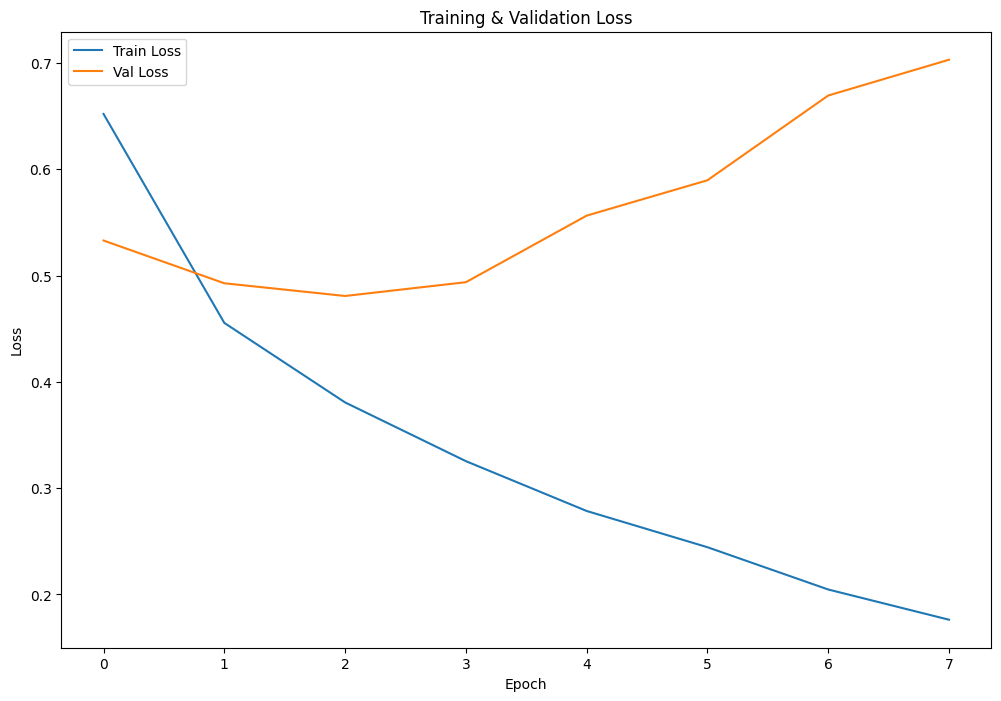

The learning curves are generated in pdf: training_validation_losses.pdf


'training_validation_losses.pdf'

In [44]:
# ---------------------------------------------------
# Plot training and validation loss
# ---------------------------------------------------
plot_losses_to_pdf(train_losses=tr_losses,
                   val_losses=val_losses,
                   pdf_filename="training_validation_losses.pdf",
                   figsize=(12, 8),
                   show_plot=True)

In [45]:
# Test accuracy (W2V)
model_rnn_w2v.eval()
correct_w2v, total_w2v = 0, 0

with torch.no_grad():
    for xb, yb in test_loader_seq:
        preds = model_rnn_w2v(xb).argmax(1)
        correct_w2v += (preds == yb).sum().item()
        total_w2v   += yb.size(0)

test_acc_w2v = 100.0 * correct_w2v / total_w2v
print(f"Test Accuracy (W2V): {test_acc_w2v:.2f}%")

Test Accuracy (W2V): 82.65%


## Αξιολόγηση στο Test Set

Το τελικό μοντέλο BiLSTM με Word2Vec embeddings πέτυχε:

**Test Accuracy: 82.65%**

### Παρατηρήσεις
- Η επίδοση είναι υψηλή και δείχνει ότι το μοντέλο καταφέρνει να γενικεύσει καλά σε δεδομένα που δεν έχει ξαναδεί.  
- Η χρήση attention βοηθάει το μοντέλο να επικεντρωθεί σε tokens που έχουν μεγαλύτερη σημασία για το sentiment. 

In [46]:
# Classification report (W2V)
y_true_w2v, y_pred_w2v = get_preds(model_rnn_w2v, test_loader_seq)

from sklearn.metrics import classification_report
print(classification_report(y_true_w2v, y_pred_w2v, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.859     0.932     0.894       918
           1      0.747     0.571     0.647       310
           2      0.766     0.750     0.758       236

    accuracy                          0.827      1464
   macro avg      0.791     0.751     0.767      1464
weighted avg      0.821     0.827     0.820      1464



### Συμπεράσματα (BiLSTM + W2V με NUM)
- **Συνολικό accuracy ≈ 82.7%**: το μοντέλο γενικεύει καλά στο test set.  
- **Κλάση 0 (Negative)**: κορυφαία επίδοση, F1 ≈ 0.894 με recall 0.932 → τα αρνητικά tweets αναγνωρίζονται πολύ καλά.  
- **Κλάση 1 (Neutral)**: δυσκολότερη, F1 ≈ 0.647 με recall 0.571 → χαμηλή κάλυψη, το μοντέλο συγχέει αρκετά τα ουδέτερα tweets με τις άλλες κλάσεις.  
- **Κλάση 2 (Positive)**: ισορροπημένη επίδοση, F1 ≈ 0.758 με recall 0.750.  

**Μέσοι όροι**:  
- Macro avg: F1 ≈ 0.767 → δείχνει μέση επίδοση ανά κλάση (χωρίς να λαμβάνεται υπόψη το μέγεθος κάθε κλάσης).  
- Weighted avg: F1 ≈ 0.820 → συνολική επίδοση λαμβάνοντας υπόψη τις αναλογίες των κλάσεων.  

Το μοντέλο αποδίδει πολύ καλά στις κλάσεις *negative* και *positive*, αλλά η διάκριση των *neutral* παραμένει πρόκληση. 

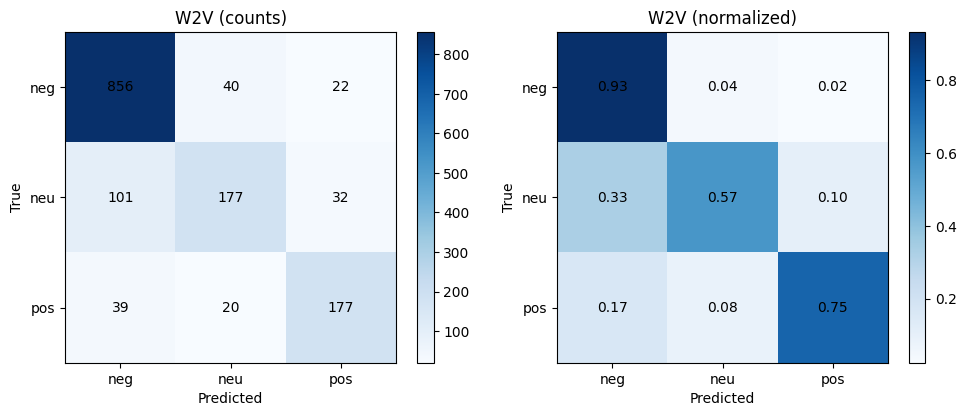

In [51]:
y_true_w2v, y_pred_w2v = get_preds(model_rnn_w2v, test_loader_seq)
plot_confusion_matrices(y_true_w2v, y_pred_w2v, ["neg", "neu", "pos"], title_prefix="W2V")

## Ανάλυση Confusion Matrix

Στα confusion matrices οι γραμμές δείχνουν τις **πραγματικές κλάσεις** (True), ενώ οι στήλες τις **προβλεπόμενες** (Predicted).

- **Counts matrix (αριστερά)**: δείχνει τον απόλυτο αριθμό παραδειγμάτων σε κάθε κατηγορία.  
  Παράδειγμα: αν στη γραμμή *neg* και στήλη *pos* υπάρχει το 25, σημαίνει ότι 25 αρνητικά tweets ταξινομήθηκαν λανθασμένα ως θετικά.  

- **Normalized matrix (δεξιά)**: κάθε γραμμή έχει κανονικοποιηθεί ώστε να δείχνει **ποσοστά ανά κλάση**.  
  Έτσι μπορούμε να δούμε πόσο καλά προβλέπει το μοντέλο κάθε κλάση ανεξάρτητα από το πόσα παραδείγματα είχε.  
  Παράδειγμα: αν στη γραμμή *neu* και στήλη *neu* βλέπουμε 0.82, σημαίνει ότι το 82% των ουδέτερων tweets προβλέφθηκαν σωστά.  

Γενικά:  
- Διαγώνιος = σωστές προβλέψεις.  
- Εκτός διαγωνίου = λάθη (π.χ. σύγχυση ανάμεσα σε *neg* και *neu*).  
- Όσο πιο “μπλε” η διαγώνιος, τόσο καλύτερη η ακρίβεια του μοντέλου.